In [1]:
import joblib
joblib.cpu_count()

32

In [55]:
# !pip install --upgrade pip

import os
from joblib import Parallel, delayed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from sklearn.svm import OneClassSVM
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")


print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER

In [3]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM_125 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)


VALID_ROBUST_OCSVM_250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_2000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [4]:
P = VALID_ROBUST_OCSVM_2000
P.ocsvm_step_width = int(P.window_size * .5)

In [5]:
P.user_ids+=[47]

In [6]:
P.num_sample_points_per_exp=18000

In [7]:
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
raw_dfList_exp1, raw_dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [53]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
# split_idx = 2 * (len(randomized_data_idx)//3) + 1
# train_set = randomized_data_idx[: split_idx]
# test_set = randomized_data_idx[split_idx: ]
# # train_set = randomized_data_idx
# print(f"train_set: {train_set}\ntest_set: {test_set}")
# # train_set = test_set
# # test_set = train_set
# print(f"train_set: {train_set}\ntest_set: {test_set}")

In [54]:
randomized_data_idx

[13,
 7,
 17,
 11,
 29,
 27,
 26,
 20,
 8,
 21,
 16,
 3,
 22,
 25,
 6,
 19,
 1,
 24,
 28,
 5,
 0,
 12,
 14,
 9,
 18,
 23,
 2,
 15,
 10,
 4]

In [10]:
# num_sample_points_per_exp_user_47 = 18000
# df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
# dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

# raw_dfList_exp1_user_47 = dfList_exp1_user_47
# raw_dfList_exp2_user_47 = dfList_exp2_user_47

In [11]:
print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

NameError: name 'train_set' is not defined

In [ ]:
print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

In [ ]:
raw_dfList_exp1_user_47[0]

In [16]:
def make_raw_X_exp(raw_df, windows):
    '''
    returns a list of window chuncks of raw_df based on the window indeces that are given.
    '''
    df_lst=[]
    for i in range(len(windows)):
        df_window=raw_df.iloc[windows[i], :].copy()
        df_lst.append(df_window)
    
    return df_lst

def delete_diagonal(array):
    '''
    returns a matrix whose diagonal is deleted. this is meant for the disimilarity matrix of the owner vs owner,
    since for owner vs owner the diagonal is 0 and does not have any meaning
    '''
    
    # index 1 of shape corresponds to columns of the matrix, and the result should have one less number of columns
    result_shape=(array.shape[0], array.shape[1]-1, array.shape[2])
    result = np.full(result_shape, np.nan, dtype=array.dtype)
    for i in range(array.shape[0]):
        
        # omit the diagonal element
        result[i] = np.concatenate((array[i, :i], array[i, i+1:]), axis=0)
        
    return result

# def forward_moving_average(data, window_size):
#     """
#     Compute the Forward Moving Average (FMA) of the given data.

#     Parameters:
#     - data: A 1-dimensional array or list of data points.
#     - window_size: The number of data points to include in the average, moving forward.

#     Returns:
#     - A 1-dimensional array of the forward moving averages.
#     """
#     n = len(data)
#     fma = np.empty(n)
    
#     # For each data point, calculate the FMA
#     for i in range(n):
#         # Determine the end index for the current window
#         end_idx = i + window_size
#         # If the window extends beyond the data, truncate it
#         if end_idx > n:
#             end_idx = n
#         # Compute the average for the current window
#         fma[i] = np.mean(data[i:end_idx])
        
#     return fma


def FMA(df, winsize):
    """
    FMA is defined because WACA uses it on their paper, we can also add it to our own experiments
    Compute the Forward Moving Average (FMA) by reversing the data,
    computing the SMA on the reversed data using pandas, and reversing the result back.

    Parameters:
    - data: A 1-dimensional array or list of data points.
    - window_size: The number of data points to include in the average, moving forward.

    Returns:
    - A 1-dimensional array of the forward moving averages.
    """
    # Reverse the input data
    reversed_df = df[::-1]
    # Create a pandas Series from the reversed data
    
    # Compute the SMA on the reversed data using pandas rolling mean
    sma = get_SMAed_df(reversed_df, winsize)

    # Reverse the result back
    return sma[::-1]

In [148]:
def make_FRR_dist_matrix_dict(dfList_exp, user_idx_set, window_size = 1000, step = 1000, numSamplePoints= 18000):
    '''
    dfLists are of the same size.
    '''
        
    users_exp_df_dict = {user_key: dfList_exp[user_key] for user_key in user_idx_set}
    print(f"len(exp1_df_user_set_dict): {len(exp_df_user_set_dict)}")
    fma_winsize=3
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    owner_owner_dis_matrix_dict={}
    for user_key in users_exp_df_dict:
        
        raw_df=FMA(users_exp_df_dict[user_key], fma_winsize)
        
        X_exp=make_raw_X_exp(raw_df, windows)
        
        encoding_array_exp = WACA_feature_extractor(X_exp)
        
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Fit on the data and transform it
        scaled_encoding_array_exp = scaler.fit_transform(encoding_array_exp)
        
        dis_matrix = (scaled_encoding_array_exp[None, :] - scaled_encoding_array_exp[:, None])
        
        dis_matrix = delete_diagonal(dis_matrix)

        owner_owner_dis_matrix_dict[user_key]=dis_matrix
        
            
    return owner_owner_dis_matrix_dict

def make_dist_matrix_dict(dfList_exp, user_idx_set, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=3):
    
    # convert dfList to a user: df dictionary such that the keys are indeces coming from user_idx_set
    users_exp_df_dict = {user_key: dfList_exp[user_key] for user_key in user_idx_set}
    print(f"len(users_exp_df_dict): {len(users_exp_df_dict)}")
    
    # windows list for slicing the user raw_df into lst of df_windows
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    # contains a list of the dis matrix of owner vs itself, the dis is given in a list of one element
    owner_owner_dis_matrix_dict={}
    
    # contains a list of dis matrices of an each owner against other users
    owner_adversary_dis_matrix_dict={}
    
    # calculate and save the owner waca encoding arrays to save computational time
    owner_encoding_array_dict={}
    unknown_encoding_array_dict={}
    
    user_fitted_scaler_dict={}
    for user_key in users_exp_df_dict:
        
        # apply FMA on the entirety of user data before slicing
        raw_df=FMA(users_exp_df_dict[user_key], fma_winsize)
        
        # sclicing user data into predefined windows
        X_exp=make_raw_X_exp(raw_df, windows)
        
        # extracting waca features for each window
        encoding_array_exp = WACA_feature_extractor(X_exp)
        
        # fit scaler on user x and transform user x data
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1), clip=True)

        # Fit on the data
        user_fitted_scaler_dict[user_key] = scaler.fit(encoding_array_exp)
        
        # and transform it
        scaled_encoding_array_exp = user_fitted_scaler_dict[user_key].transform(encoding_array_exp)
        
        
        owner_encoding_array_dict[user_key] = scaled_encoding_array_exp
        
        
        unknown_encoding_array_dict[user_key] = encoding_array_exp
    
    
    
    
    for owner_key in users_exp_df_dict:
        
        # initializing
        owner_owner_dis_matrix_dict[owner_key]=[]
        owner_adversary_dis_matrix_dict[owner_key]=[]
        
        for unknown_key in users_exp_df_dict:
            
            scaled_unknown_encoding_array = user_fitted_scaler_dict[owner_key].transform(unknown_encoding_array_dict[unknown_key])
            
            print(f"num zeroes for {owner_key}, unknown_key: {unknown_key}, {np.sum(scaled_unknown_encoding_array==0)/(84*len(scaled_unknown_encoding_array))}")
            print(f"num ones for {owner_key}, unknown_key: {unknown_key}, {np.sum(scaled_unknown_encoding_array==1)/(84*len(scaled_unknown_encoding_array))}")
            
            if  owner_key==13 and unknown_key==8:
                print(scaled_unknown_encoding_array)
                print(owner_encoding_array_dict[owner_key])
            
                return scaled_unknown_encoding_array, owner_encoding_array_dict[owner_key]
            
            # calculate the disimilarity matrix between the owner and the unkown user data
            dis_matrix = (owner_encoding_array_dict[owner_key][None, :] - scaled_unknown_encoding_array[:, None])
            
            # if it is owner vs owner
            if owner_key == unknown_key:
                
                # delete as the diagonal is all zeros and does not mean anything
                dis_matrix = delete_diagonal(dis_matrix)

                owner_owner_dis_matrix_dict[owner_key].append(dis_matrix)
            
            else:
                
                owner_adversary_dis_matrix_dict[owner_key].append(dis_matrix)
        
                
    
    return {"owner_owner_dis_matrix_dict": owner_owner_dis_matrix_dict, "owner_adversary_dis_matrix_dict": owner_adversary_dis_matrix_dict}


In [138]:
user_8_exp_1=raw_dfList_exp1[8].drop(["time_stamp"], axis=1)
user_13_exp_1=raw_dfList_exp1[13].drop(["time_stamp"], axis=1)

In [149]:
result=make_dist_matrix_dict(raw_dfList_exp1, randomized_data_idx, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=20)

len(users_exp_df_dict): 30
num zeroes for 13, unknown_key: 13, 0.05555555555555555
num ones for 13, unknown_key: 13, 0.03835978835978836
num zeroes for 13, unknown_key: 7, 0.14351851851851852
num ones for 13, unknown_key: 7, 0.21891534391534392
num zeroes for 13, unknown_key: 17, 0.26256613756613756
num ones for 13, unknown_key: 17, 0.19378306878306878
num zeroes for 13, unknown_key: 11, 0.1474867724867725
num ones for 13, unknown_key: 11, 0.11044973544973545
num zeroes for 13, unknown_key: 29, 0.08068783068783068
num ones for 13, unknown_key: 29, 0.1917989417989418
num zeroes for 13, unknown_key: 27, 0.36177248677248675
num ones for 13, unknown_key: 27, 0.11177248677248677
num zeroes for 13, unknown_key: 26, 0.18716931216931218
num ones for 13, unknown_key: 26, 0.07407407407407407
num zeroes for 13, unknown_key: 20, 0.32605820105820105
num ones for 13, unknown_key: 20, 0.13227513227513227
num zeroes for 13, unknown_key: 8, 0.14947089947089948
num ones for 13, unknown_key: 8, 0.4199735

In [154]:
for v in result[0]:
    print(v)
    print('\n')

[0.         1.         1.         0.         0.         1.
 0.         1.         1.         0.49259606 0.30331888 1.
 1.         1.         1.         0.40998263 1.         1.
 1.         0.89265128 1.         0.483517   0.44015015 0.22907075
 1.         1.         1.         0.5403302  1.         1.
 0.         0.         0.27078218 0.11341275 0.         0.
 1.         1.         1.         0.57467001 0.         0.
 1.         1.         1.         0.61470197 1.         1.
 1.         1.         1.         0.58133687 1.         1.
 0.56589144 0.96251294 1.         0.45229539 0.         0.
 0.66364793 0.18330738 1.         0.         0.         1.
 0.09096251 0.53663153 0.15579556 1.         1.         1.
 1.         1.         1.         0.4136597  1.         1.
 0.83669882 0.         0.57475899 0.30129019 0.         0.        ]


[0.         1.         1.         0.         0.23015396 0.67575717
 0.         1.         1.         0.2106175  0.         0.
 1.         1.         1.    

In [130]:
result=make_dist_matrix_dict(raw_dfList_exp1, randomized_data_idx, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=20)

len(users_exp_df_dict): 30
num zeroes for unknown_key: 13, 0.05555555555555555
num ones for unknown_key: 13, 0.03505291005291005
num zeroes for unknown_key: 7, 0.0
num ones for unknown_key: 7, 0.0
num zeroes for unknown_key: 17, 0.0
num ones for unknown_key: 17, 0.0
num zeroes for unknown_key: 11, 0.0
num ones for unknown_key: 11, 0.0
num zeroes for unknown_key: 29, 0.0
num ones for unknown_key: 29, 0.0
num zeroes for unknown_key: 27, 0.0
num ones for unknown_key: 27, 0.0
num zeroes for unknown_key: 26, 0.0
num ones for unknown_key: 26, 0.0
num zeroes for unknown_key: 20, 0.0
num ones for unknown_key: 20, 0.0
num zeroes for unknown_key: 8, 0.0
num ones for unknown_key: 8, 0.0
num zeroes for unknown_key: 21, 0.0
num ones for unknown_key: 21, 0.0
num zeroes for unknown_key: 16, 0.0
num ones for unknown_key: 16, 0.0
num zeroes for unknown_key: 3, 0.0
num ones for unknown_key: 3, 0.0
num zeroes for unknown_key: 22, 0.0
num ones for unknown_key: 22, 0.0
num zeroes for unknown_key: 25, 0.0
n

In [81]:
np.linalg.norm(np.concatenate(result["owner_adversary_dis_matrix_dict"][7], axis=1),  ord=2, axis=2).shape

(18, 522)

In [82]:
result.keys()
shape = (10,)  # Modify the shape according to your requirements

# Create an array of labels filled with -1
np.concatenate([np.full(shape, -1), np.full(shape, -1)])

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [83]:
def calculate_user_EER(owner_owner_dis_matrix_dict, owner_adversary_dis_matrix_dict, minkowski_p):
    
    shape = (10,)  # Modify the shape according to your requirements

    # Create an array of labels filled with -1
    labels = np.full(shape, -1)

    owner_eer_lst_dict={}
    for owner_key in owner_owner_dis_matrix_dict:
        
        owner_eer_lst_dict[owner_key]=[]
        
        owner_owner_dm=np.concatenate(owner_owner_dis_matrix_dict[owner_key], axis=1)
        owner_adversary_dm=np.concatenate(owner_adversary_dis_matrix_dict[owner_key], axis=1)
        
        owner_owner_dm = np.linalg.norm(owner_owner_dm, ord=minkowski_p, axis=2)
        owner_adversary_dm = np.linalg.norm(owner_adversary_dm, ord=minkowski_p, axis=2)
        
        pos_labels=np.full(owner_owner_dm.shape[1], 1)
        neg_labels=np.full(owner_adversary_dm.shape[1], -1)
        
        y_true=np.concatenate([pos_labels, neg_labels])
        
        for owner_window_idx in range(owner_owner_dm.shape[0]):
            
            y_score=-1*np.concatenate([owner_owner_dm[owner_window_idx], owner_adversary_dm[owner_window_idx]])
            
            owner_eer_lst_dict[owner_key].append(equal_error_rate(y_true, y_score))
            
    return owner_eer_lst_dict

In [104]:
scaler = MinMaxScaler(feature_range=(0, 1), clip=False)

# Fit on the data
user_fitted_scaler_dict[user_key] = scaler.fit(encoding_array_exp)

# and transform it
scaled_encoding_array_exp = user_fitted_scaler_dict[user_key].transform(encoding_array_exp)

raw_dfList_exp2[0]

,time_stamp,x_a,y_a,z_a,x_g,y_g,z_g
0,1.399653e+12,-0.089161,-0.012318,-0.449672,0.090281,-0.026632,-0.203998
1,1.399665e+12,-0.215283,0.051748,-0.457952,0.060187,-0.033556,-0.217048
2,1.399673e+12,-0.215283,0.051748,-0.457952,0.041545,-0.049002,-0.230896
3,1.399685e+12,-0.376685,0.269738,-0.350027,0.016245,-0.073503,-0.245277
4,1.399693e+12,-0.376685,0.269738,-0.350027,-0.019441,-0.100401,-0.257261
...,...,...,...,...,...,...,...
26938,1.652323e+12,-0.373220,-0.292160,-0.672815,0.041812,-0.058323,-0.092145
26939,1.652331e+12,-0.483021,-0.299340,-0.567661,0.064182,-0.072971,-0.081493
26940,1.652342e+12,-0.564174,-0.332568,-0.402991,0.080161,-0.097472,-0.051932
26941,1.652350e+12,-0.564174,-0.332568,-0.402991,0.113451,-0.126500,-0.032491


In [118]:
from sklearn.preprocessing import MinMaxScaler
data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18], [3, 15]]

scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
print(scaler.fit(data))

print(f"scaler.data_max_: {scaler.data_max_}")

print(scaler.transform(data))

print(scaler.transform([[-1, 1]]))
print(scaler.transform([[-1, 20]]))


MinMaxScaler()
scaler.data_max_: [ 3. 18.]
[[0.     0.    ]
 [0.125  0.25  ]
 [0.25   0.5   ]
 [0.5    1.    ]
 [1.     0.8125]]
[[ 0.     -0.0625]]
[[0.    1.125]]


In [123]:
window_size=1000
result=make_dist_matrix_dict(raw_dfList_exp2, randomized_data_idx, window_size=window_size, step=window_size, numSamplePoints= 18000, fma_winsize=2)

len(users_exp_df_dict): 30


In [124]:
# randomized_data_idx=[13, 7]

In [125]:
euclidean_result=calculate_user_EER(result["owner_owner_dis_matrix_dict"], result["owner_adversary_dis_matrix_dict"], minkowski_p=2)

0.035858291805440784


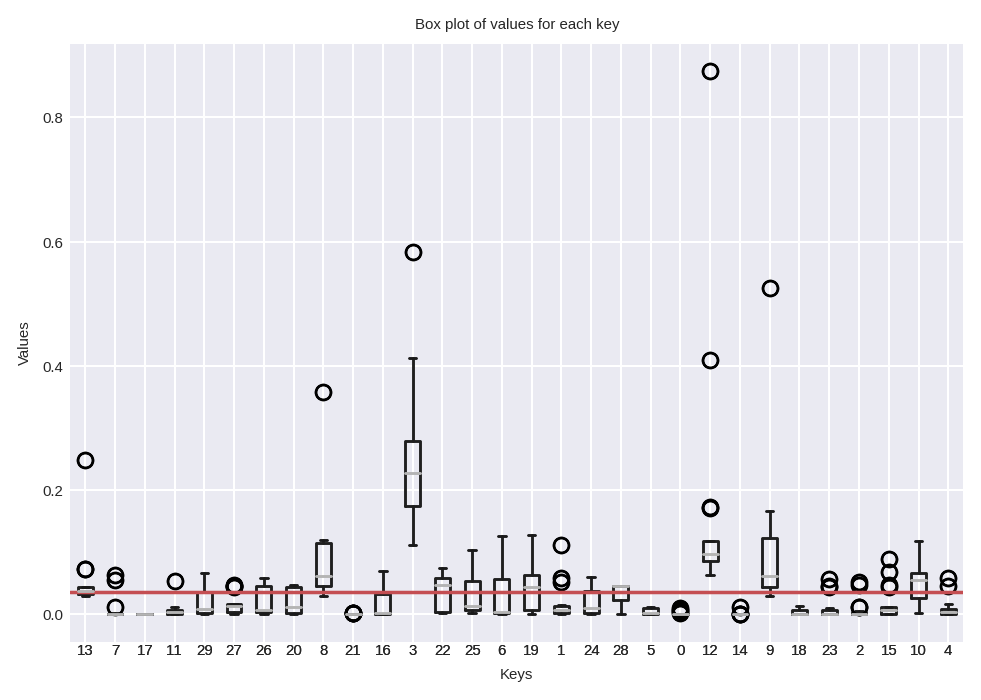

In [126]:
euclidean_result
# Convert the data to a DataFrame where each key becomes a column
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in euclidean_result.items()]))

# Create the box plot
df.boxplot()

# Calculate the average EER (assuming EER is in the data)
average_eer = df.mean(axis=0).mean()

print(average_eer)
# Create the box plot
df.boxplot()

# Add a horizontal line for the average EER
plt.axhline(y=average_eer, color='r', linestyle='-', label='Average EER')


# Add labels and title
plt.xlabel("Keys")
plt.ylabel("Values")
plt.title("Box plot of values for each key")

# Show the plot
plt.show()

fma_winsize: 1
len(users_exp_df_dict): 30
0.41581930984398874


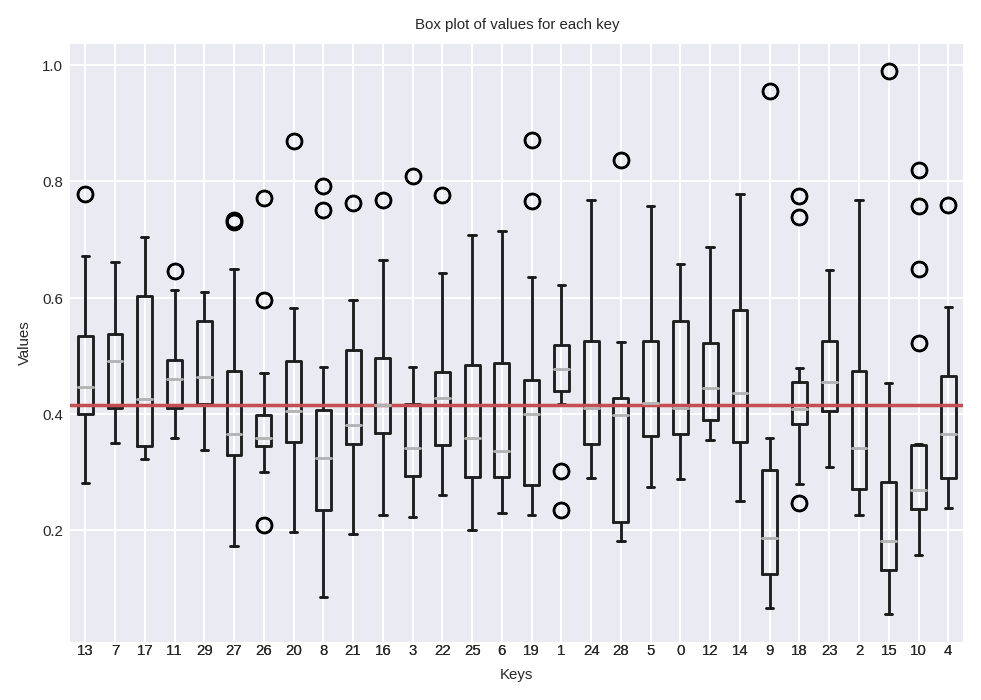

fma_winsize: 2
len(users_exp_df_dict): 30
0.41484924748954516


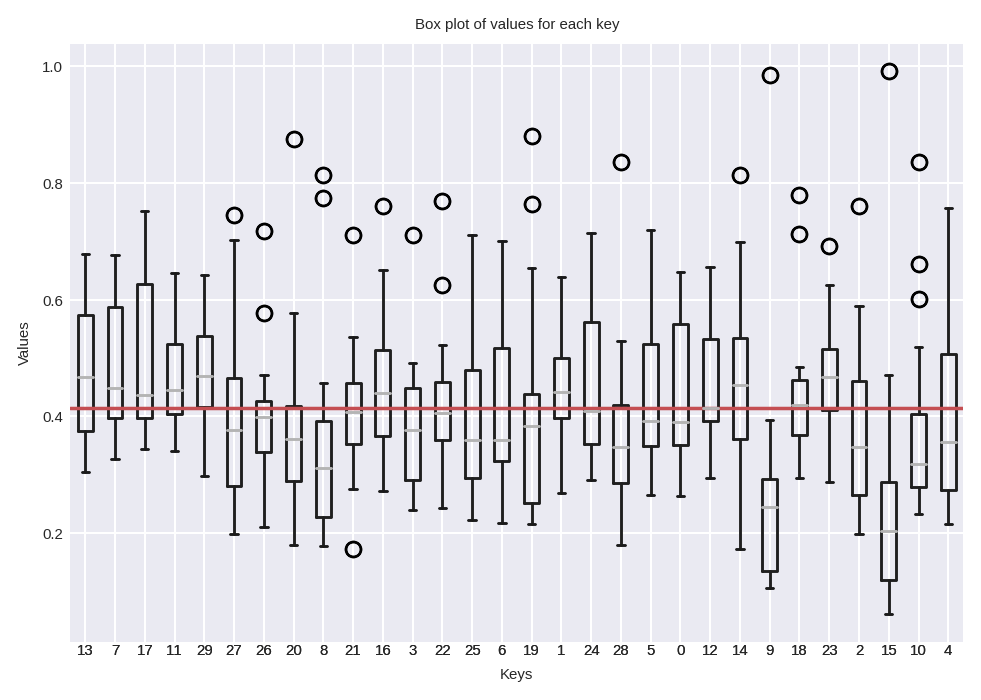

fma_winsize: 3
len(users_exp_df_dict): 30
0.4175681766959658


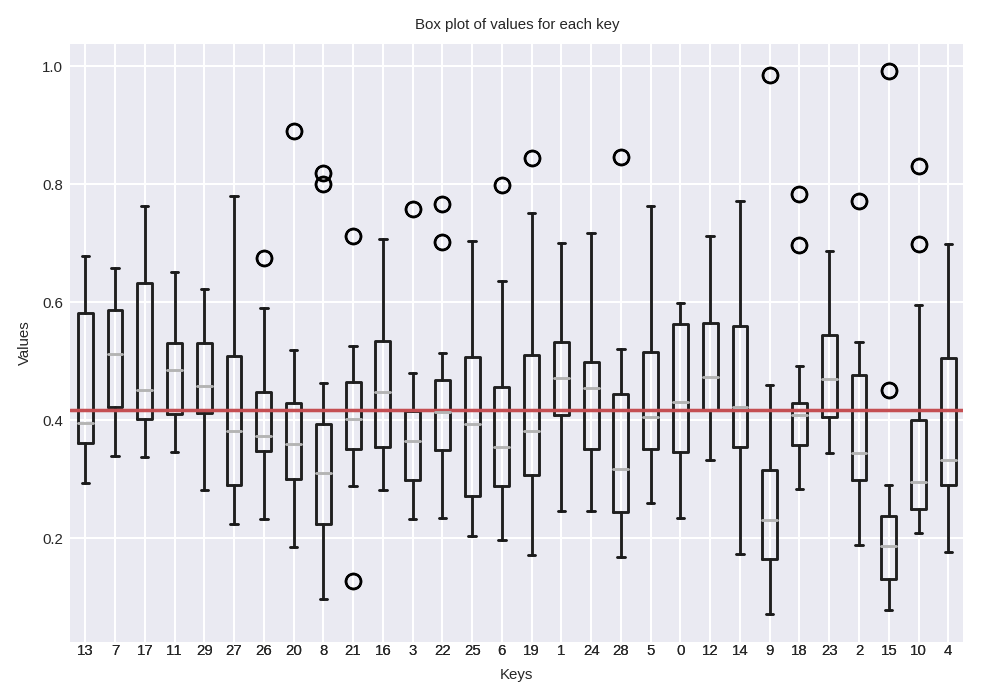

fma_winsize: 4
len(users_exp_df_dict): 30
0.4167784163473819


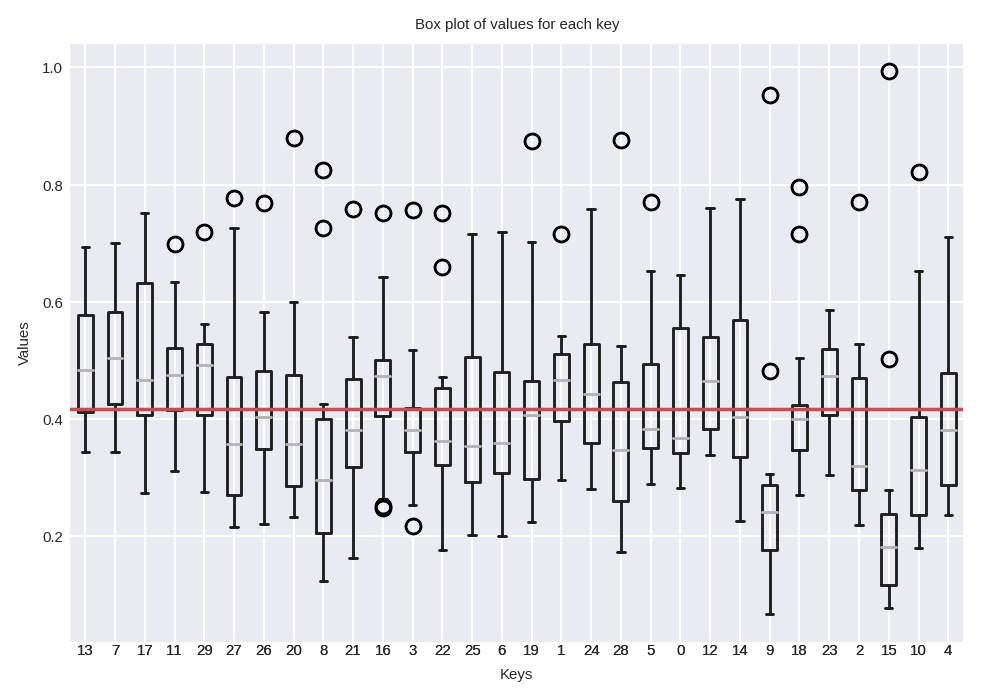

fma_winsize: 5
len(users_exp_df_dict): 30
0.4167387666007228


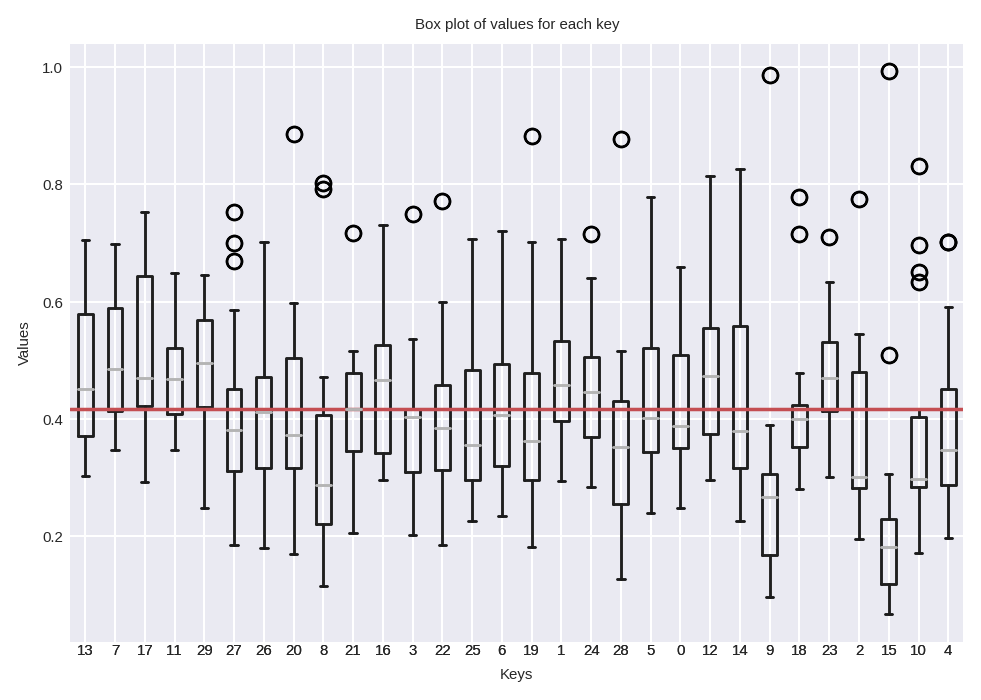

fma_winsize: 6
len(users_exp_df_dict): 30
0.41110683311212937


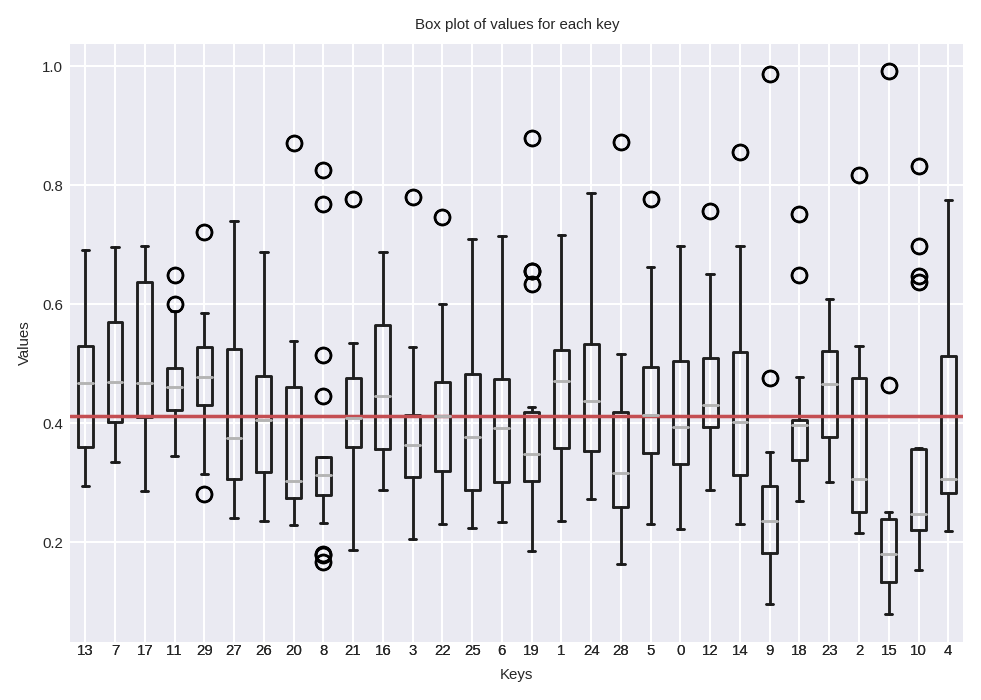

fma_winsize: 7
len(users_exp_df_dict): 30
0.4111242581323718


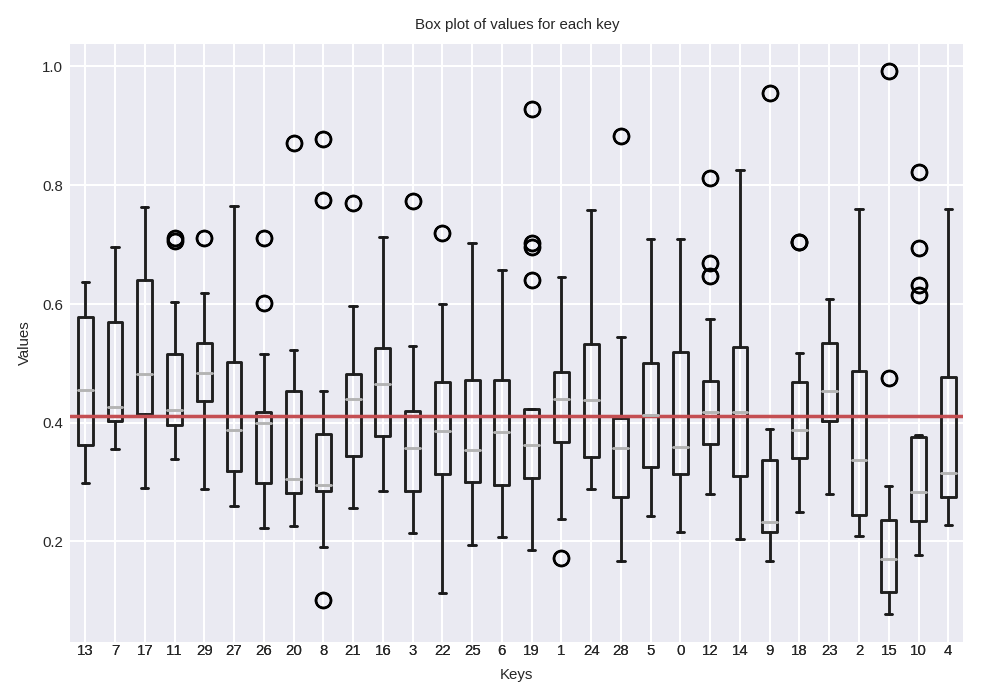

fma_winsize: 8
len(users_exp_df_dict): 30
0.4127800524211386


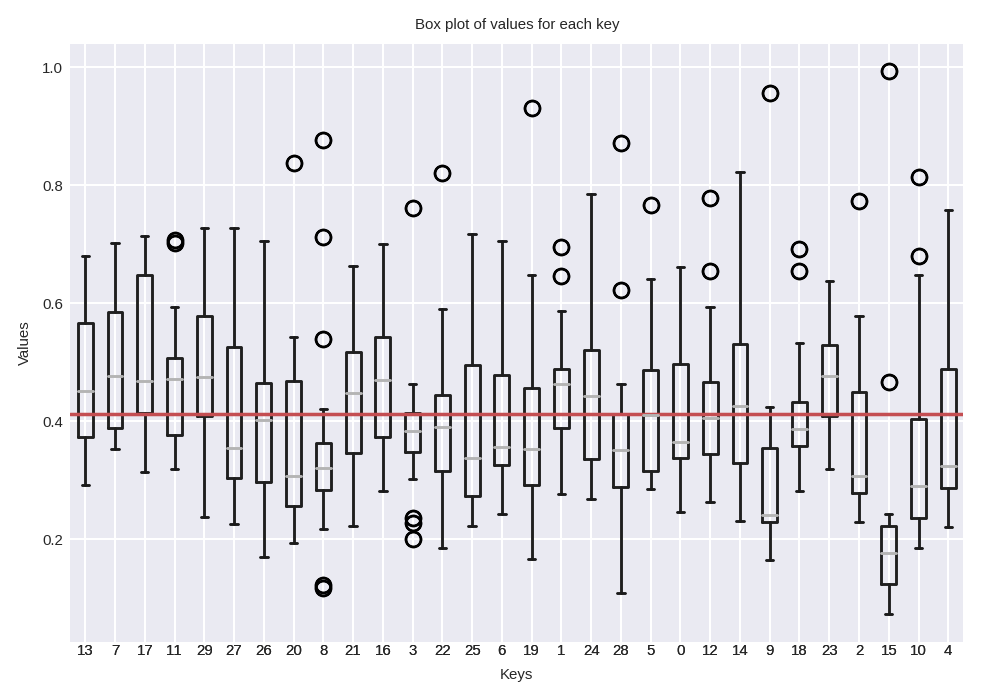

fma_winsize: 9
len(users_exp_df_dict): 30
0.41572352440337573


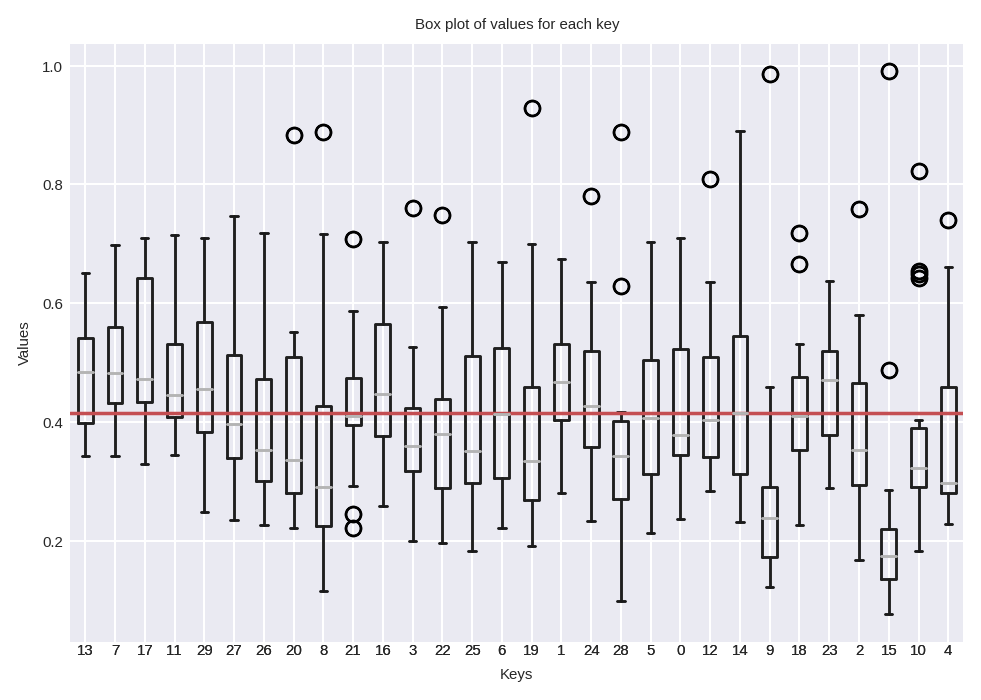

fma_winsize: 10
len(users_exp_df_dict): 30
0.4160830850007094


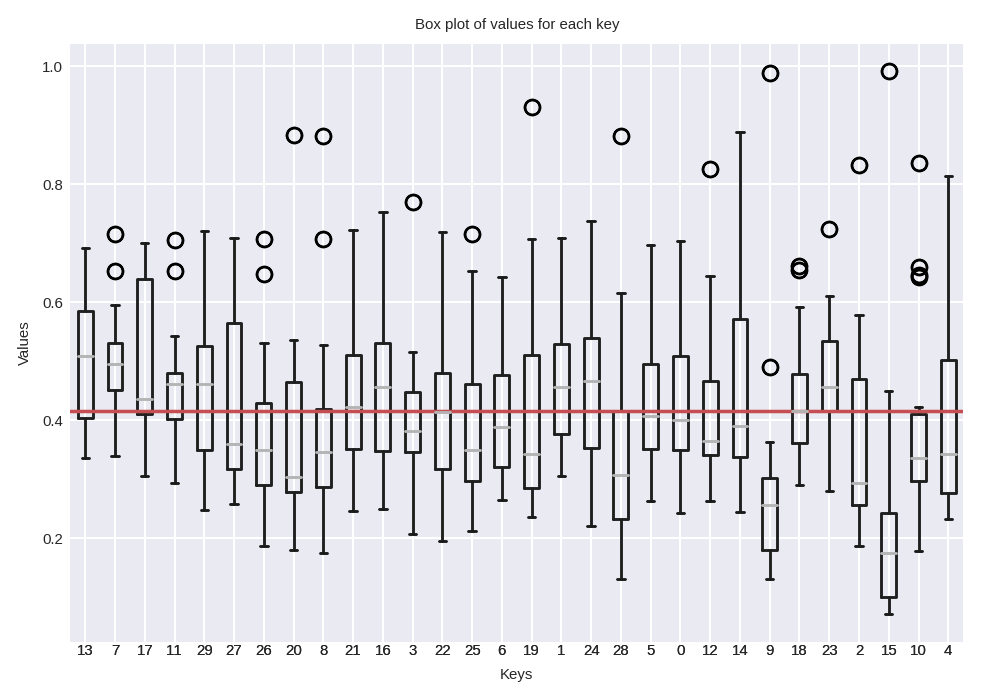

fma_winsize: 11
len(users_exp_df_dict): 30
0.4131191620965116


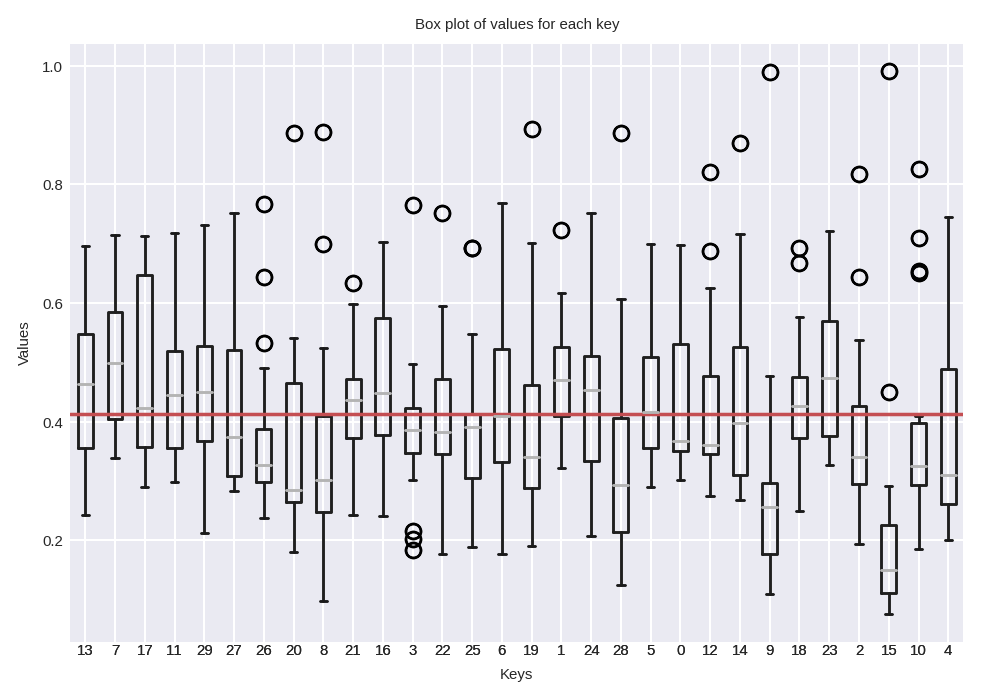

fma_winsize: 12
len(users_exp_df_dict): 30
0.4158955834355879


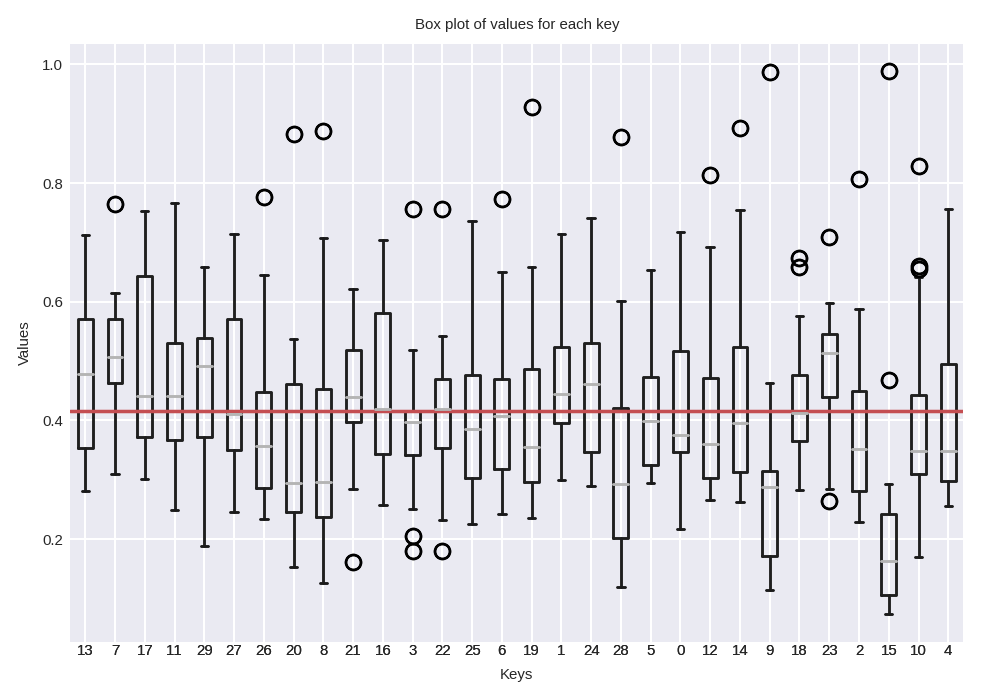

fma_winsize: 13
len(users_exp_df_dict): 30
0.4134227956827686


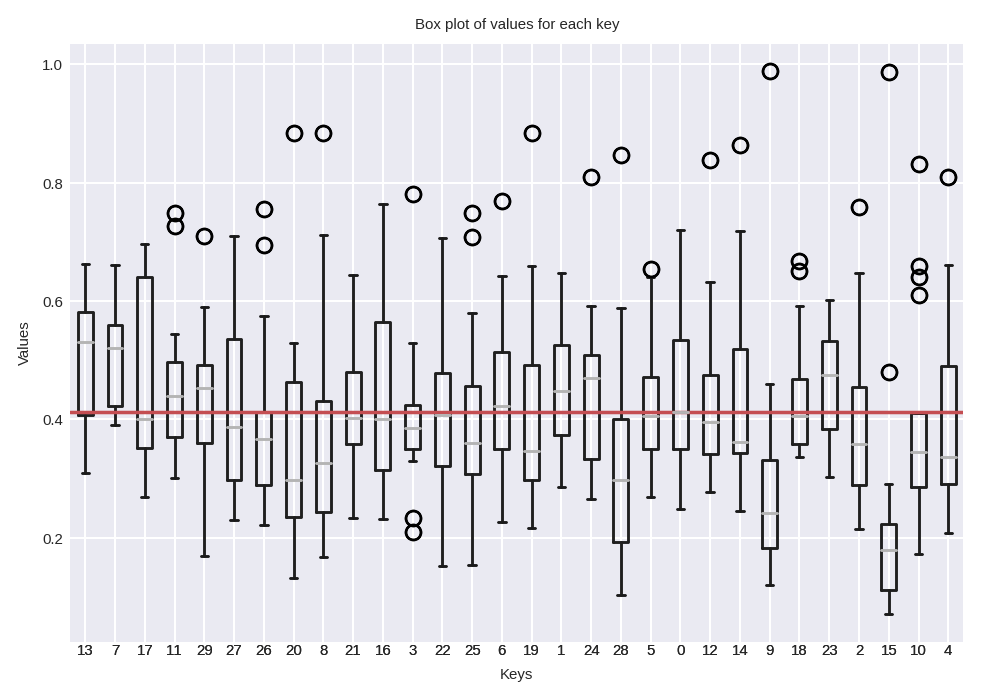

fma_winsize: 14
len(users_exp_df_dict): 30
0.41379206003388996


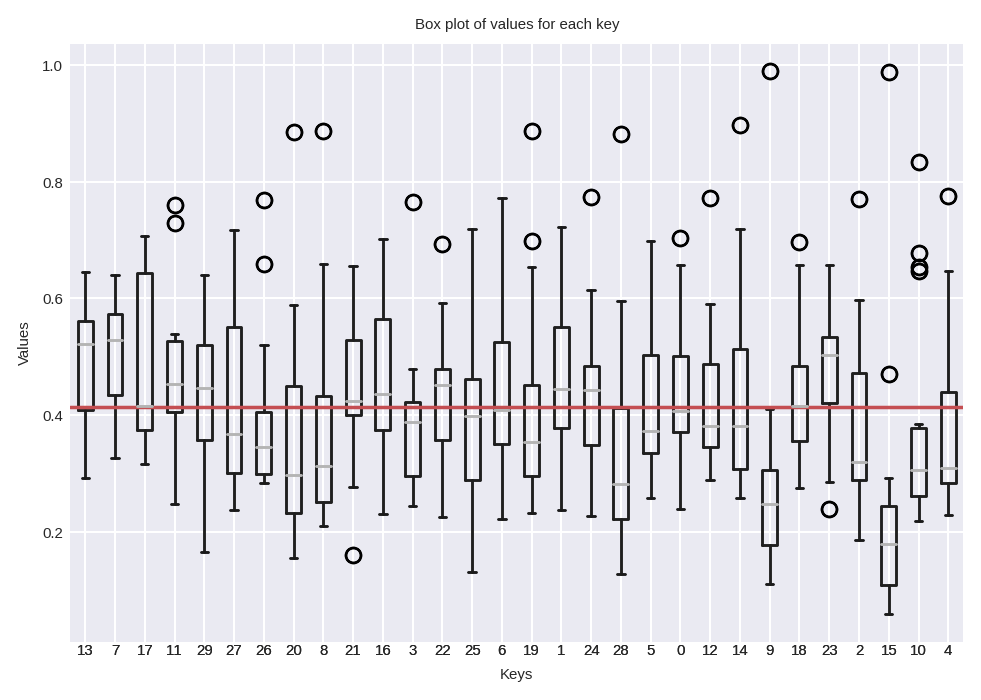

fma_winsize: 15
len(users_exp_df_dict): 30
0.41360184559136554


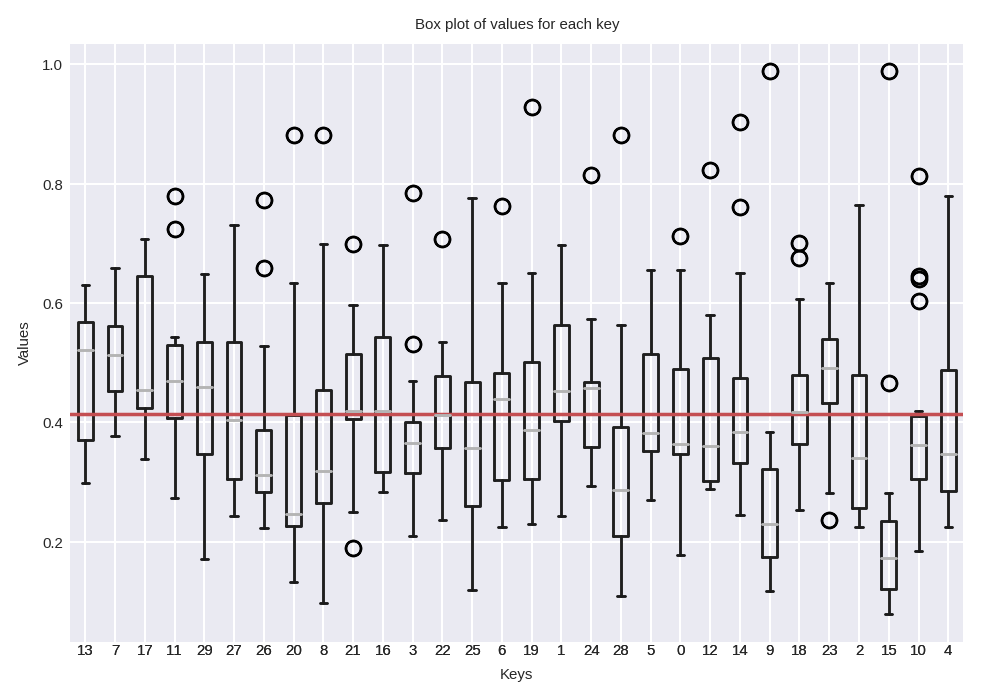

fma_winsize: 16
len(users_exp_df_dict): 30
0.41098256245878506


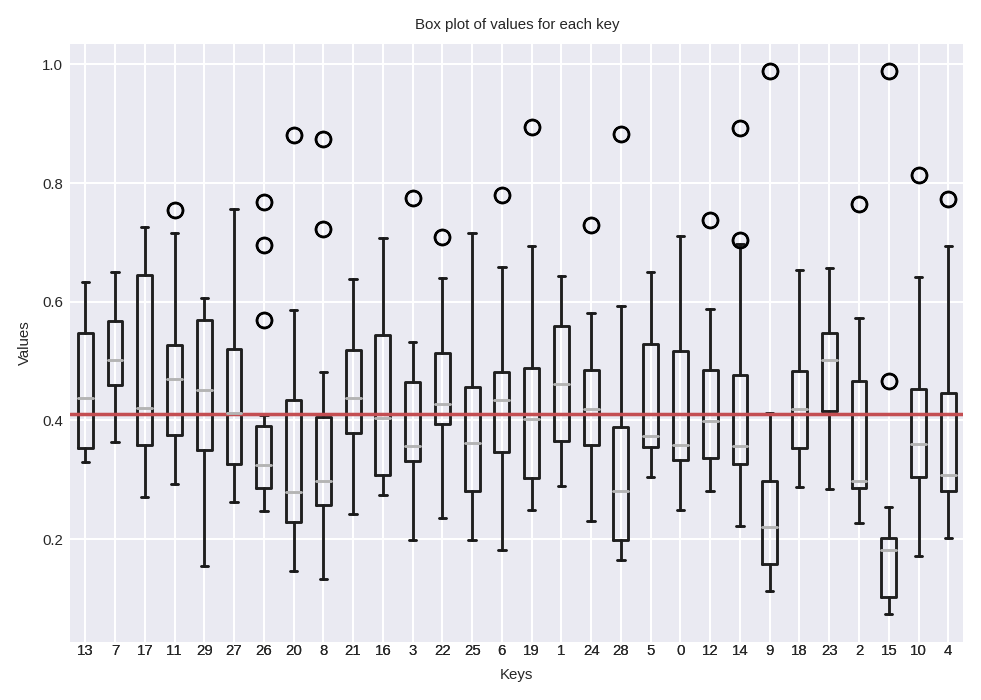

fma_winsize: 17
len(users_exp_df_dict): 30
0.4105114608636132


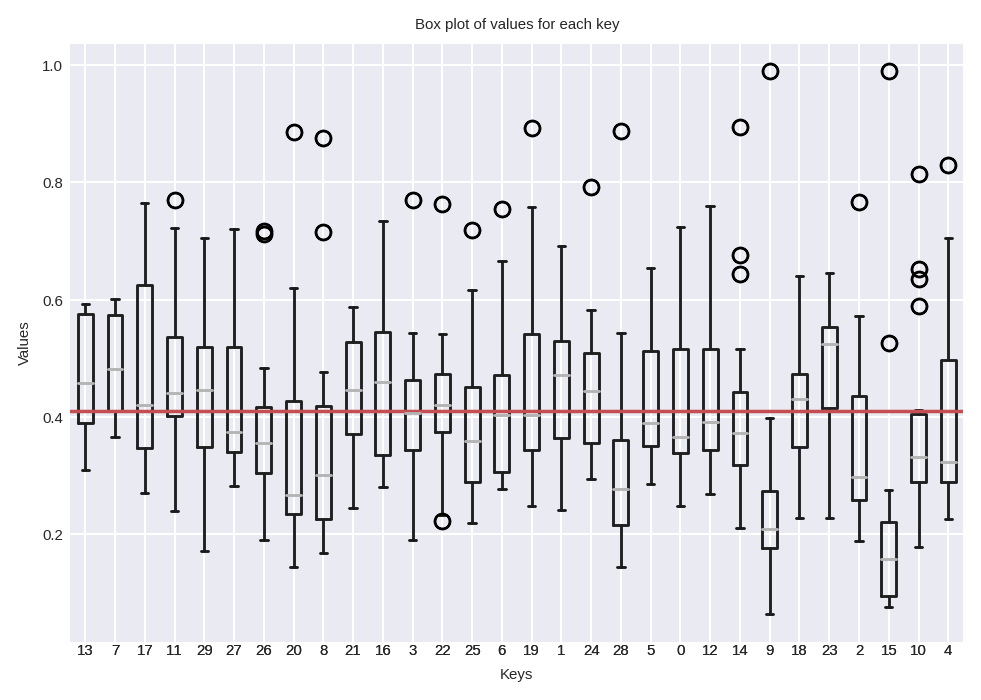

fma_winsize: 18
len(users_exp_df_dict): 30
0.4107962086494878


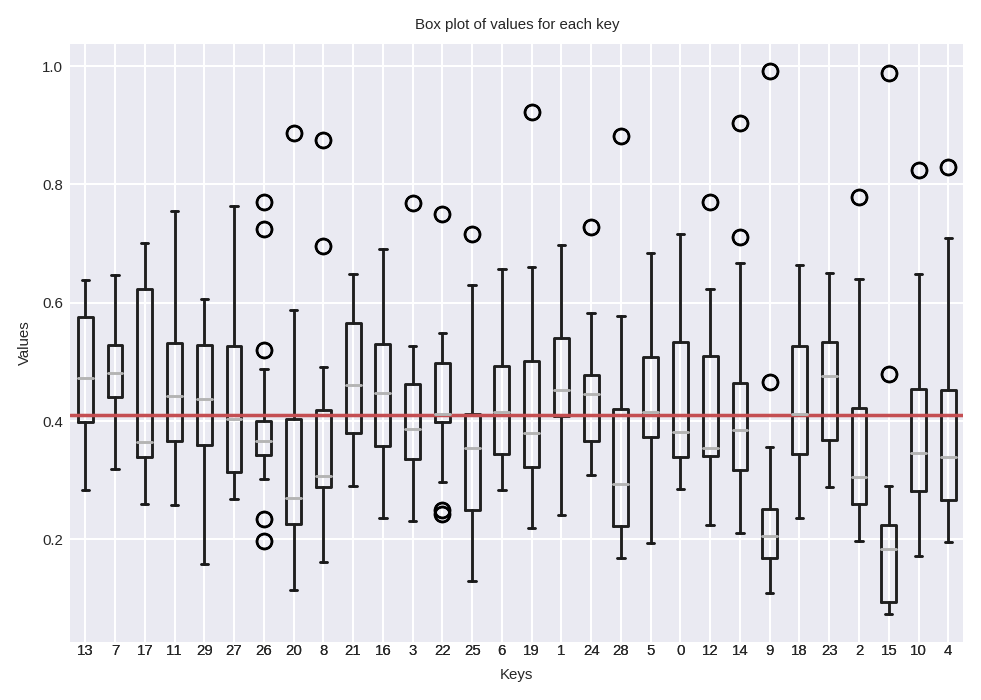

fma_winsize: 19
len(users_exp_df_dict): 30
0.410893663553118


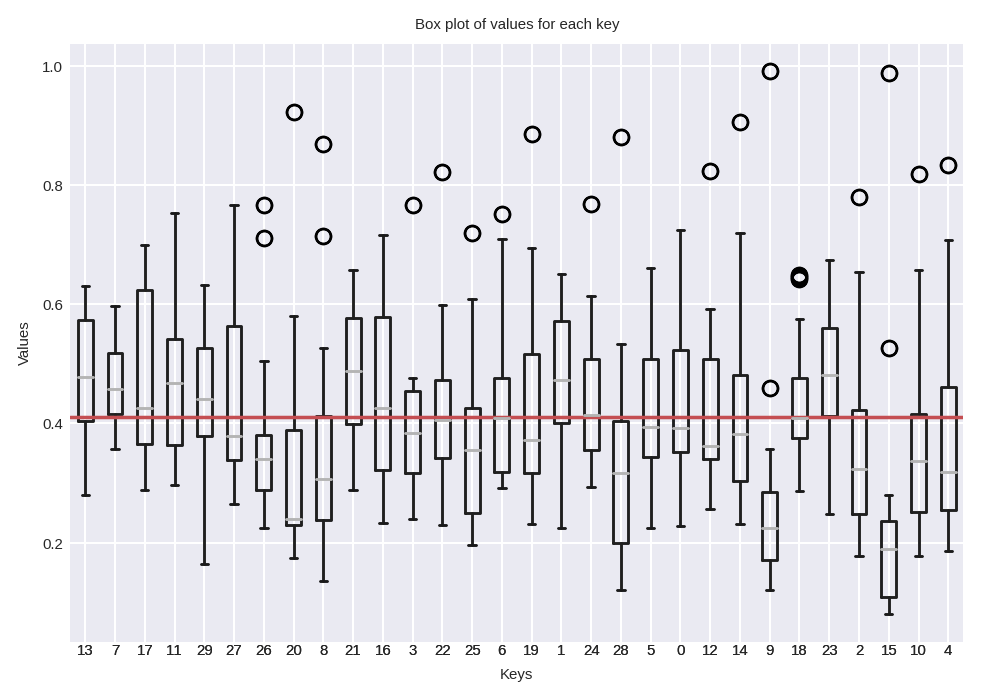

fma_winsize: 20
len(users_exp_df_dict): 30
0.4088694396447383


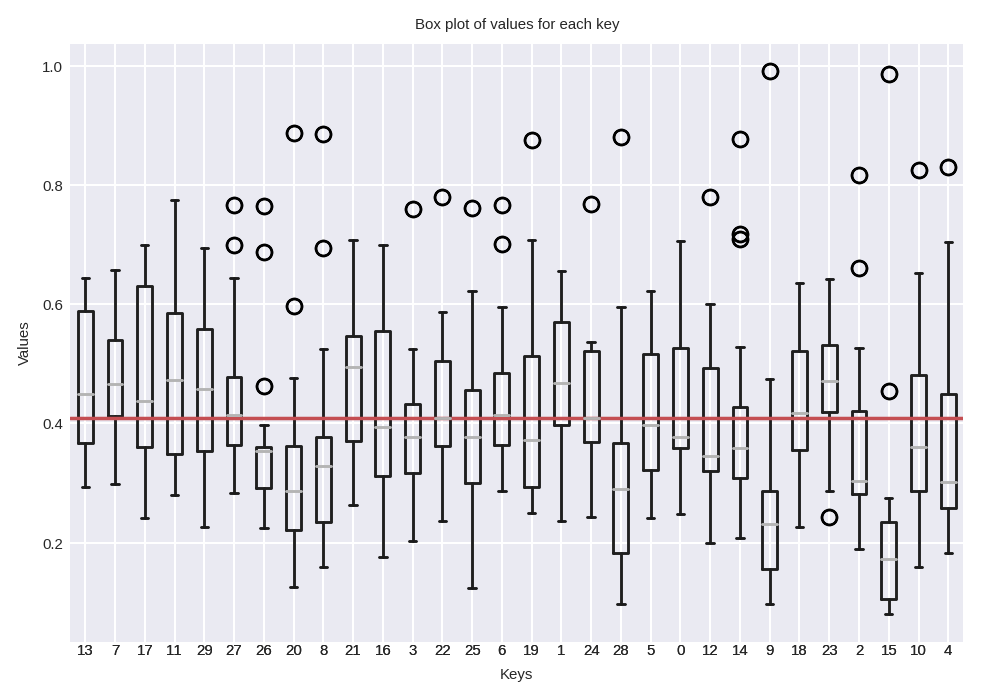

fma_winsize: 21
len(users_exp_df_dict): 30
0.4066751391914791


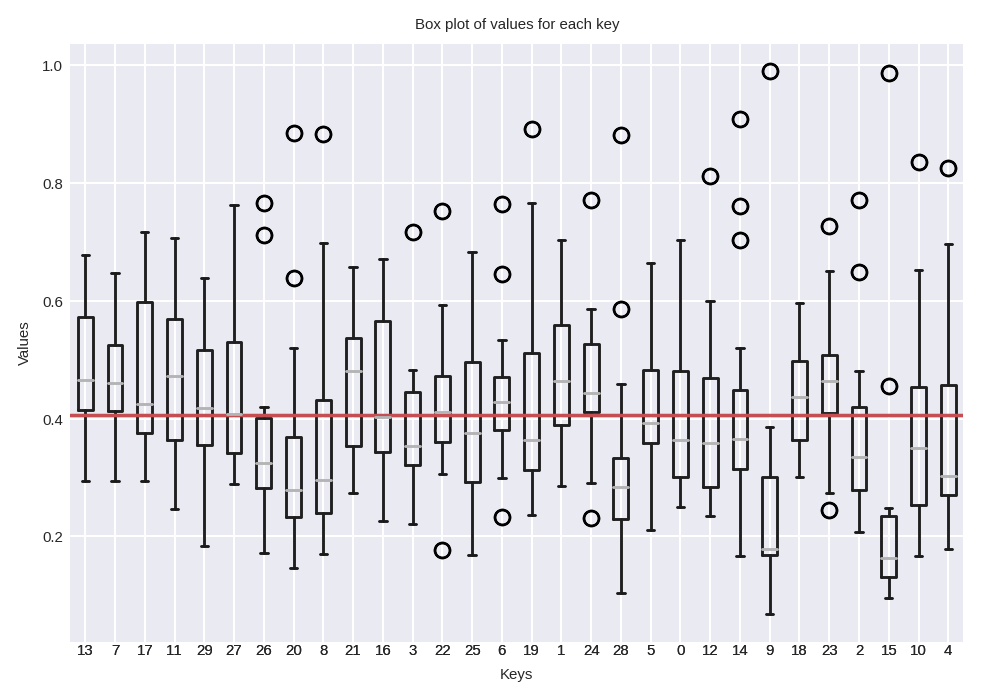

fma_winsize: 22
len(users_exp_df_dict): 30
0.4063616975099959


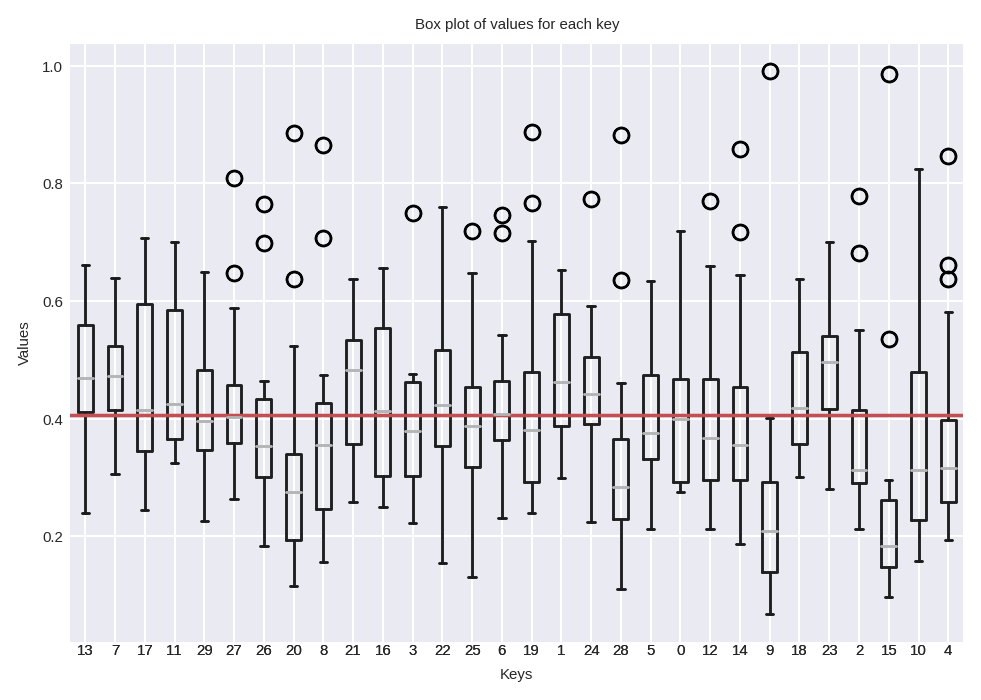

fma_winsize: 23
len(users_exp_df_dict): 30
0.40636409736308304


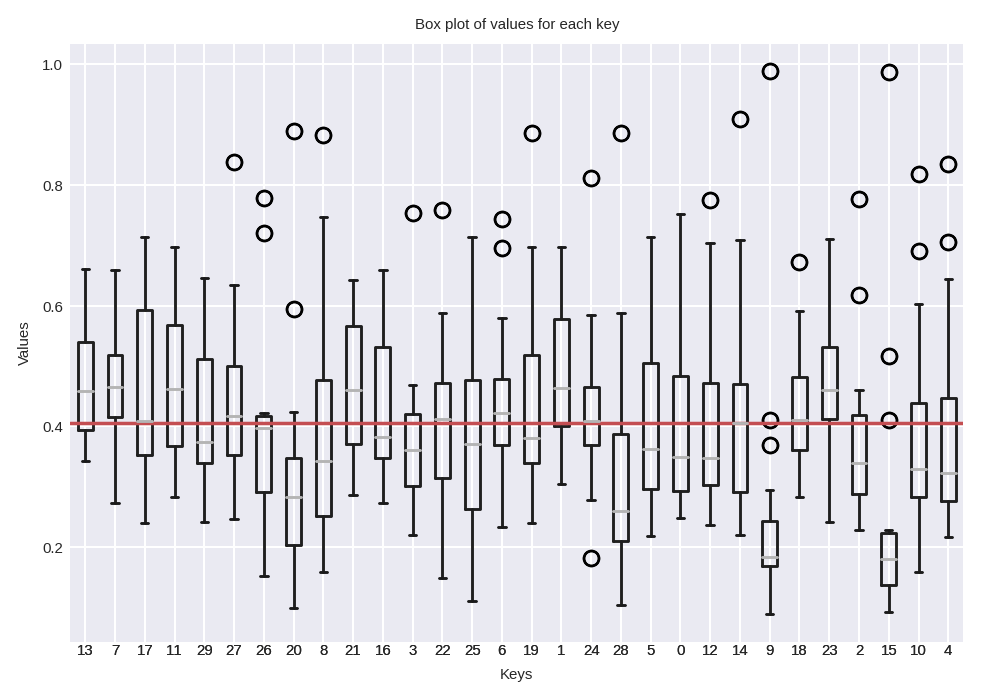

fma_winsize: 24
len(users_exp_df_dict): 30
0.40785127588711095


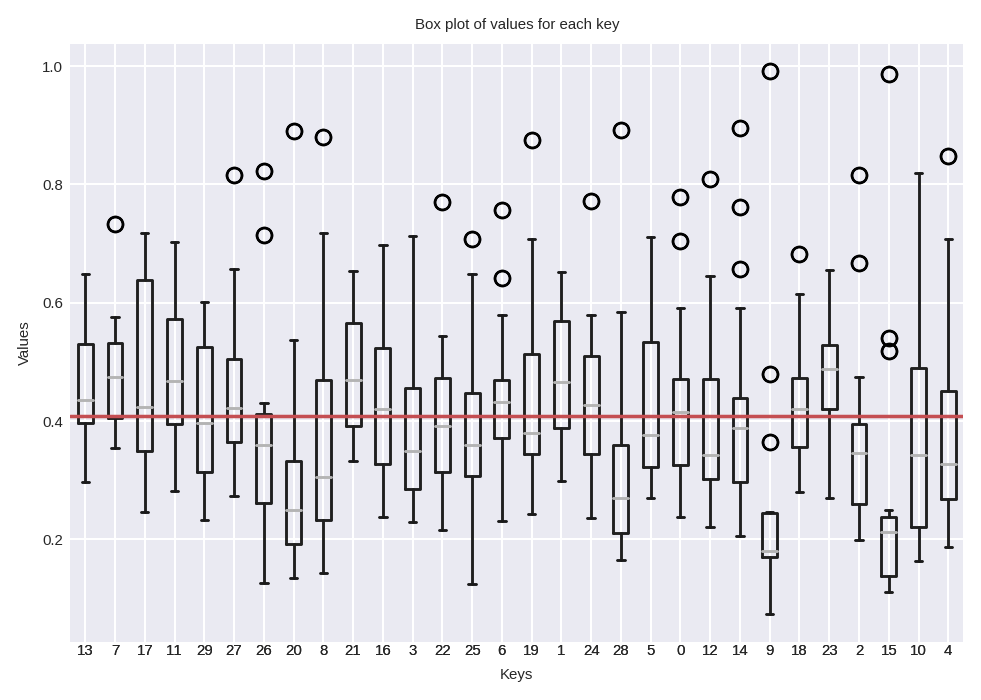

fma_winsize: 25
len(users_exp_df_dict): 30
0.40774495196120164


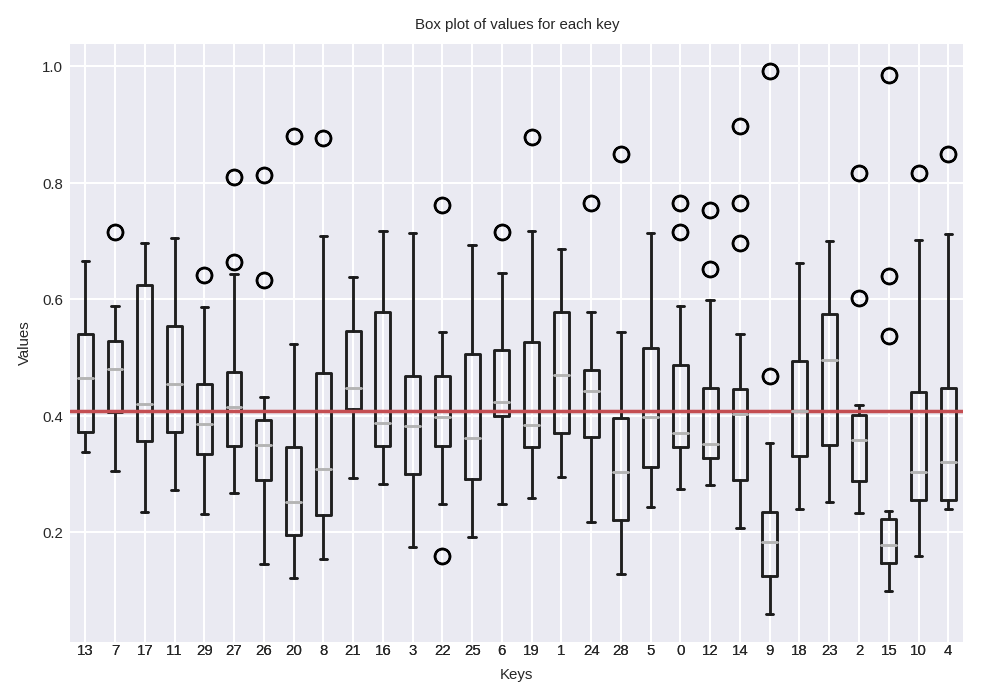

fma_winsize: 26
len(users_exp_df_dict): 30
0.4087529945992873


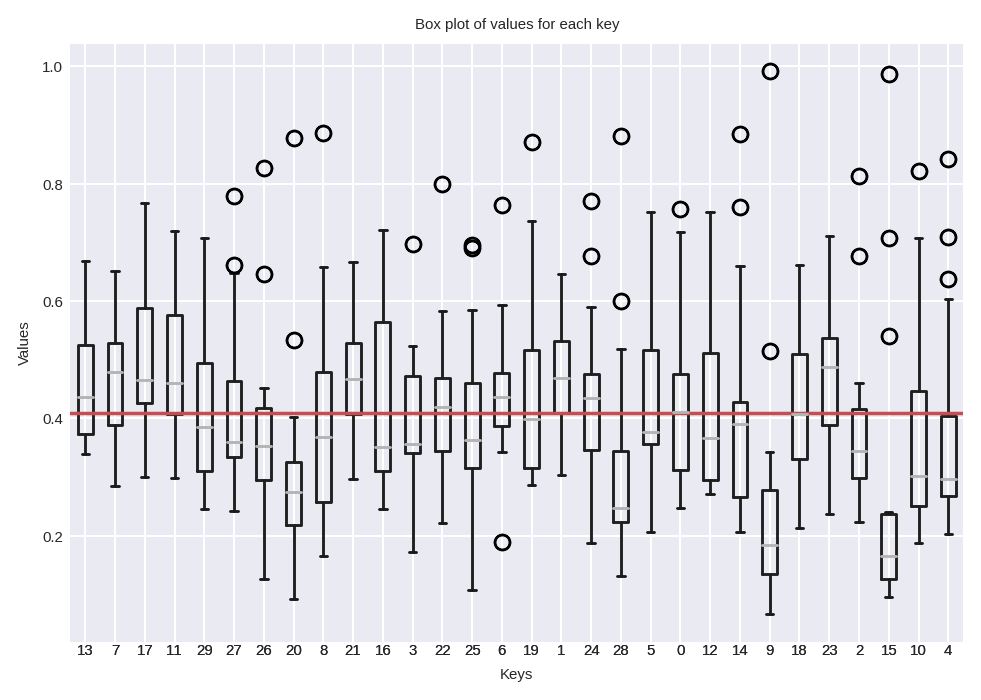

fma_winsize: 27
len(users_exp_df_dict): 30
0.40563099441564615


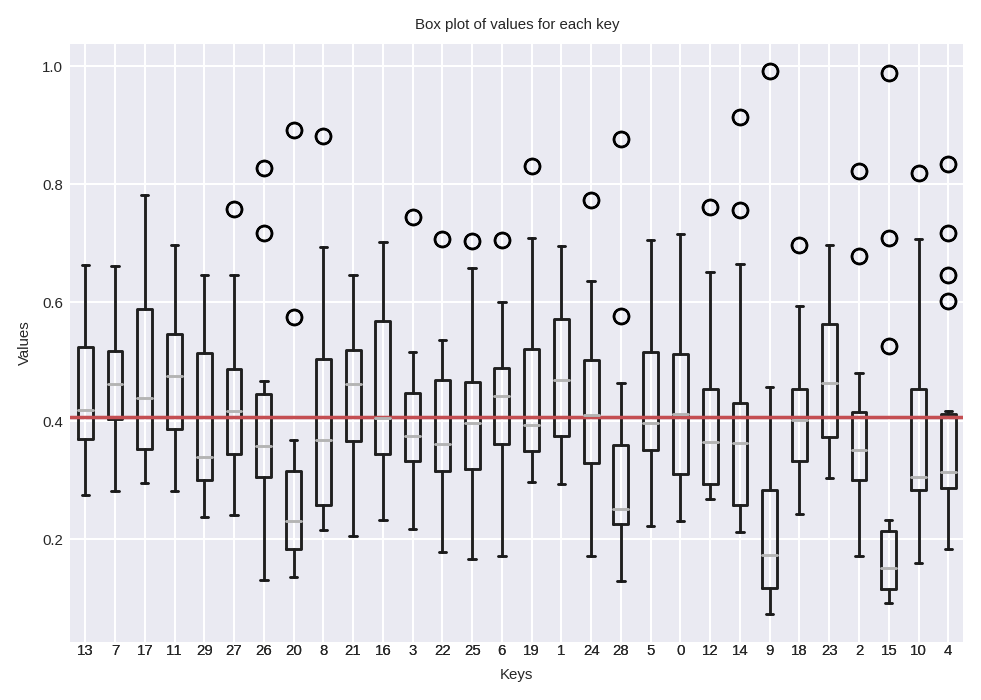

fma_winsize: 28
len(users_exp_df_dict): 30
0.40647407323934254


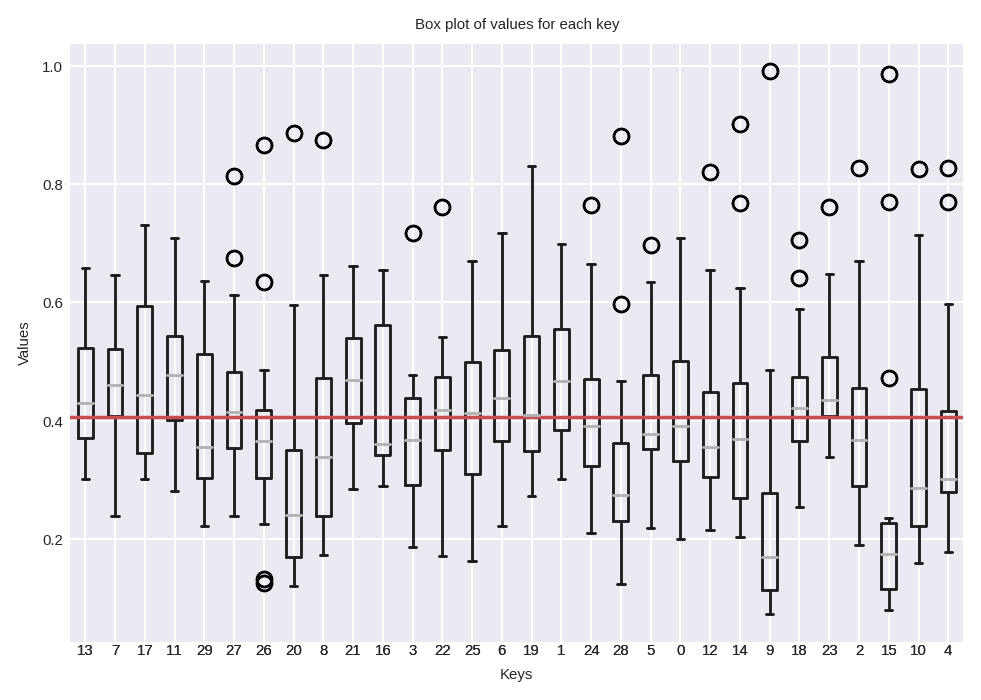

fma_winsize: 29
len(users_exp_df_dict): 30
0.406969173365387


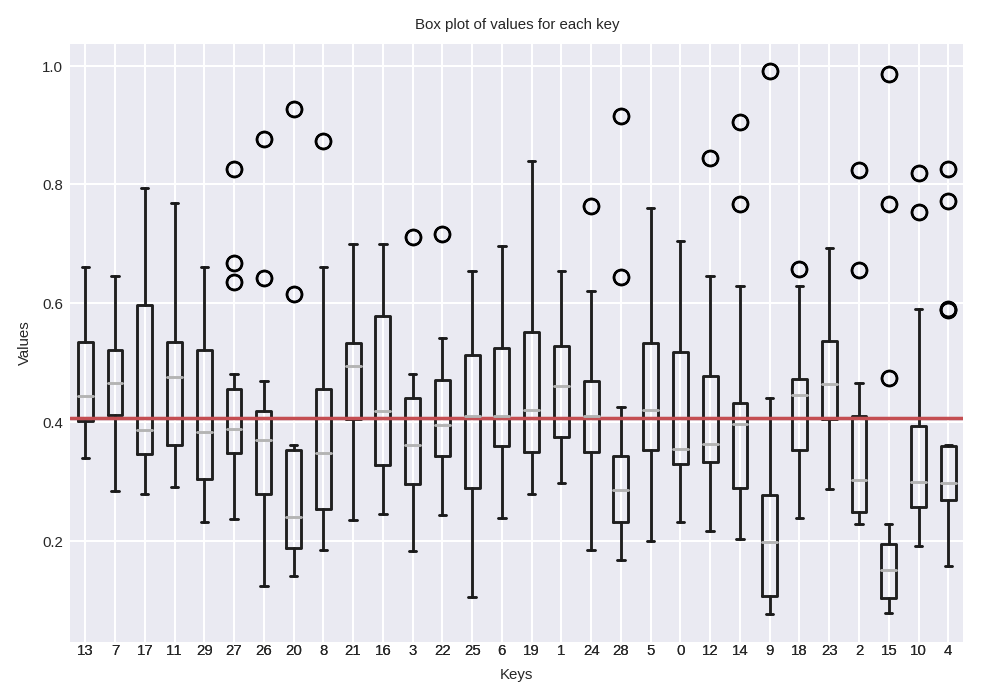

fma_winsize: 30
len(users_exp_df_dict): 30
0.4056028222272305


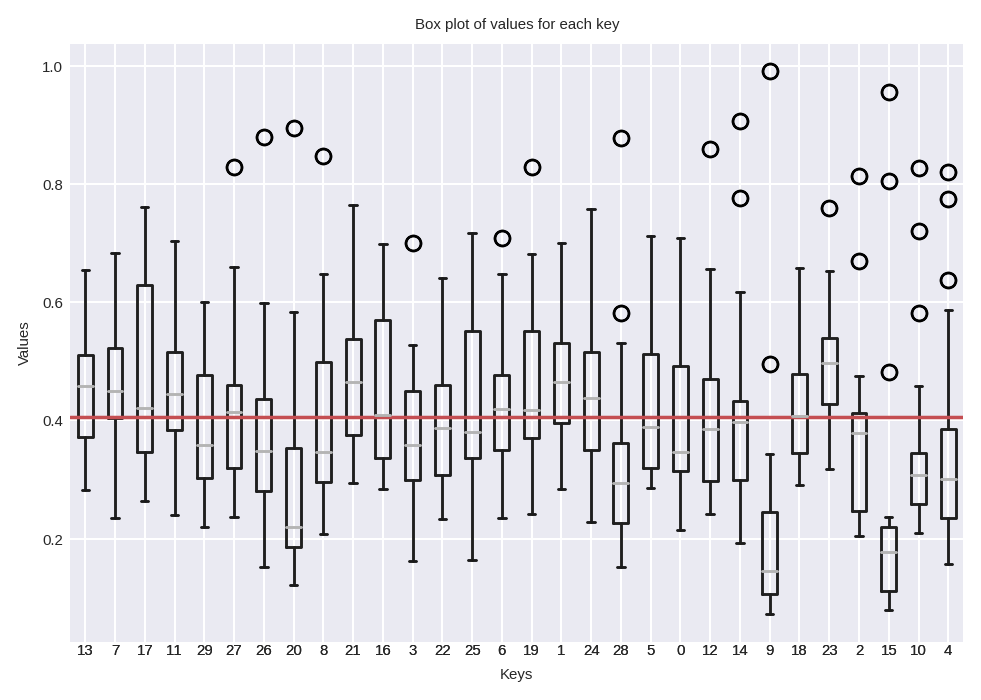

fma_winsize: 31
len(users_exp_df_dict): 30
0.40673419644571324


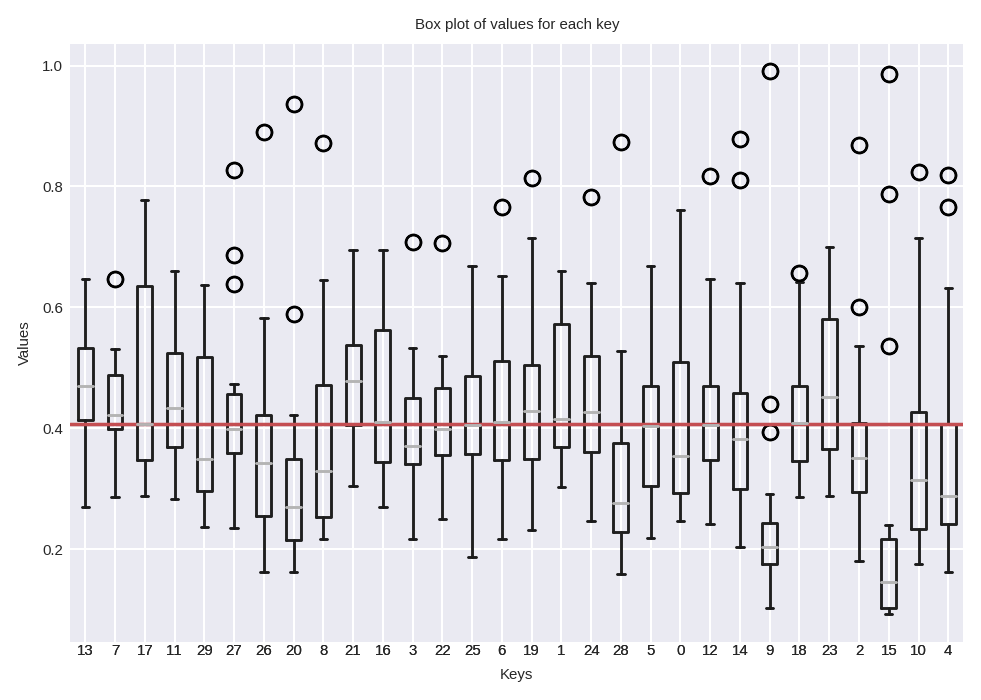

fma_winsize: 32
len(users_exp_df_dict): 30
0.4059709388225277


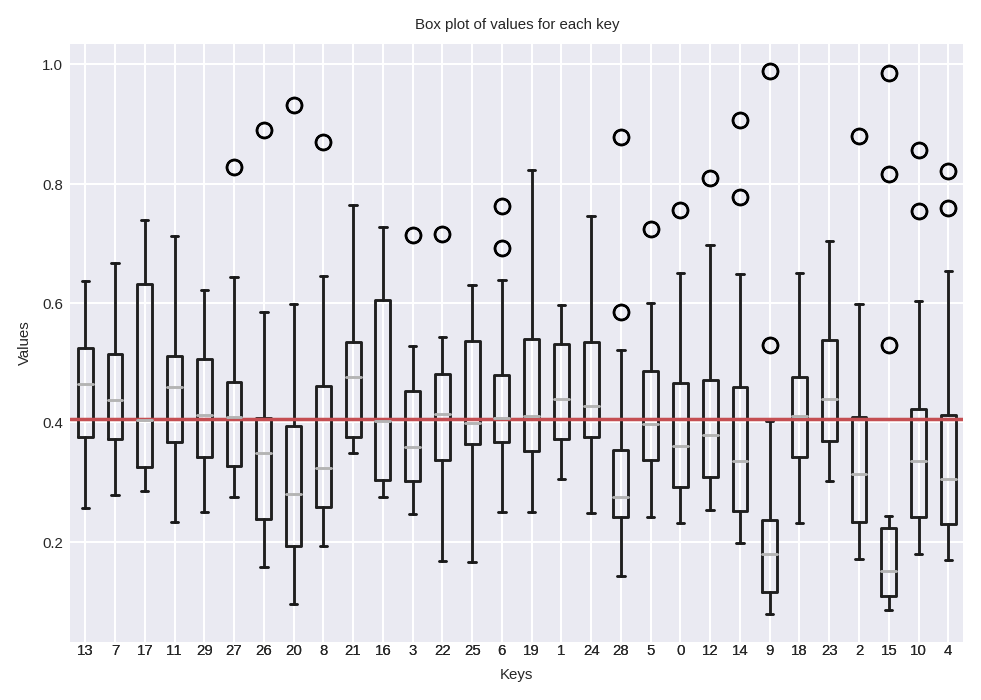

fma_winsize: 33
len(users_exp_df_dict): 30
0.4057237539545404


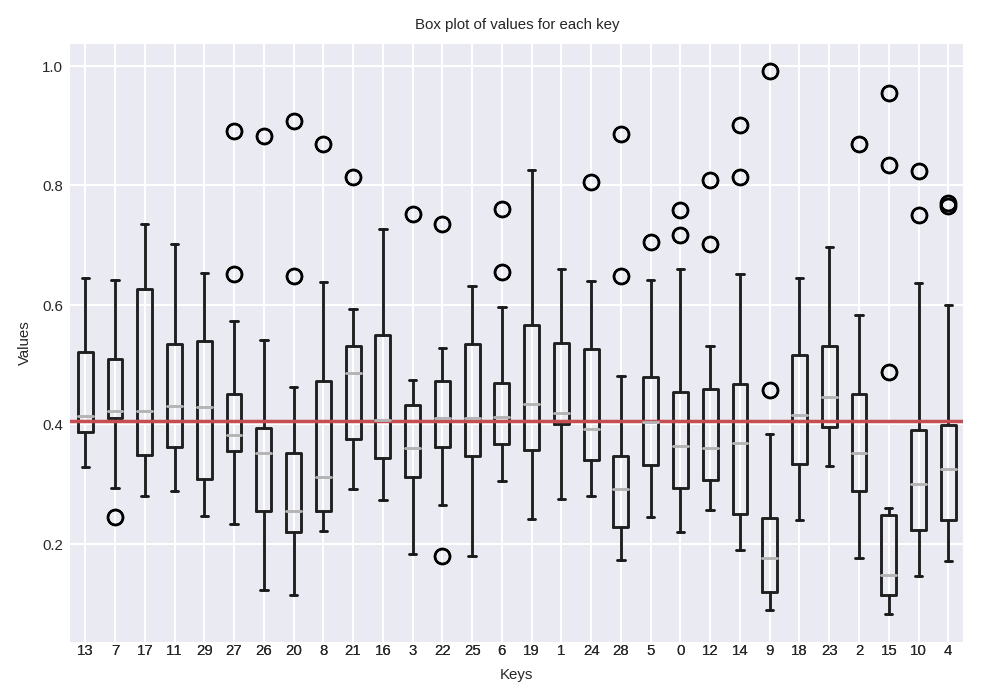

fma_winsize: 34
len(users_exp_df_dict): 30
0.4018071937161411


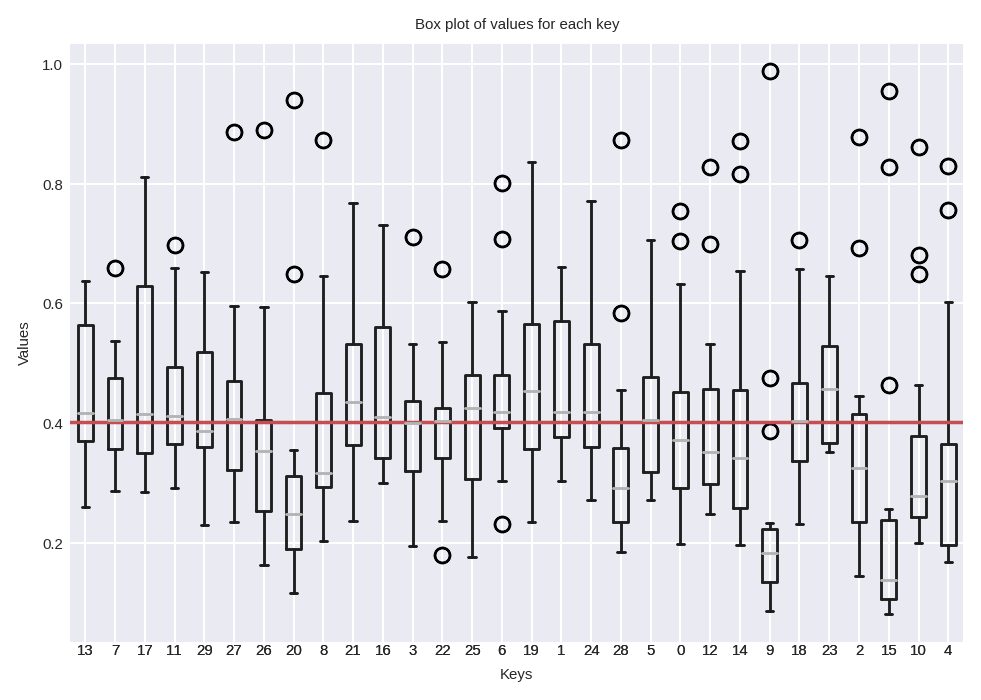

fma_winsize: 35
len(users_exp_df_dict): 30
0.4084247364335262


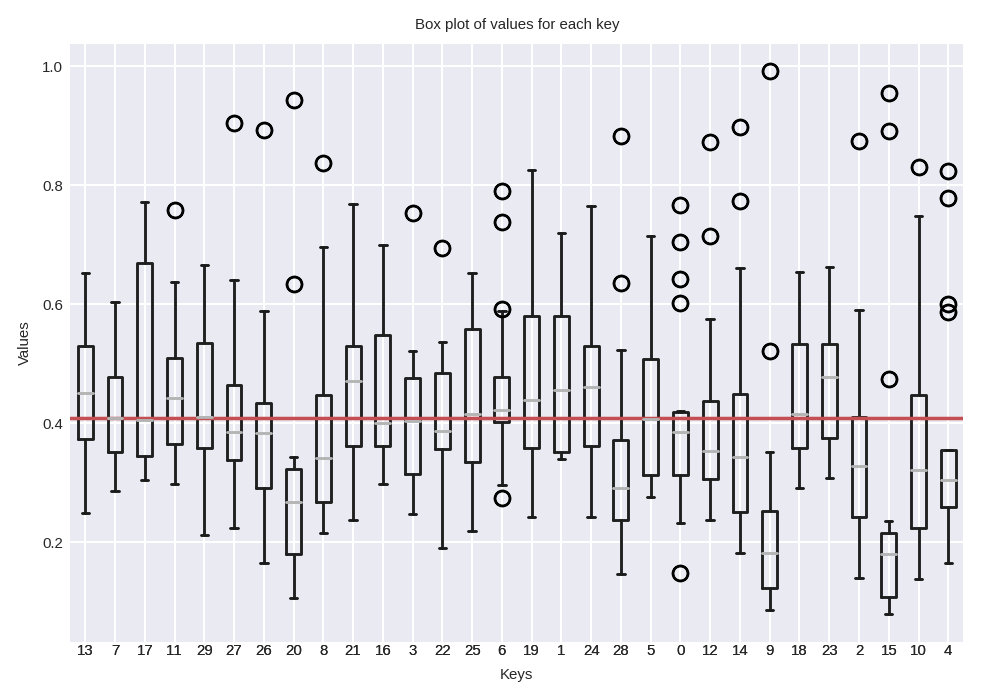

fma_winsize: 36
len(users_exp_df_dict): 30
0.4052542174809472


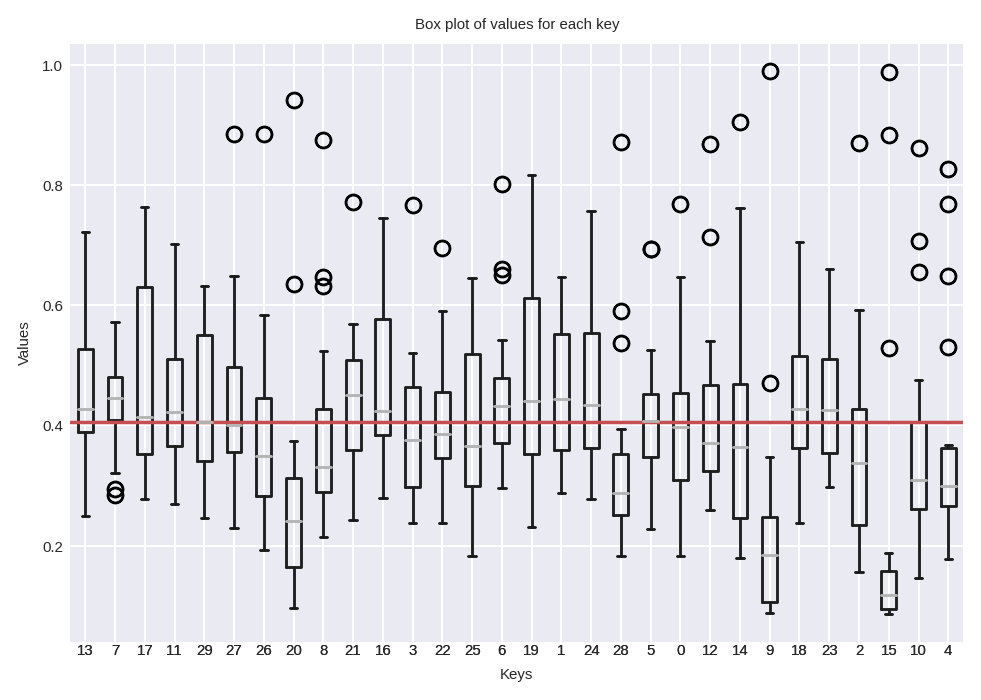

fma_winsize: 37
len(users_exp_df_dict): 30
0.4089297489962353


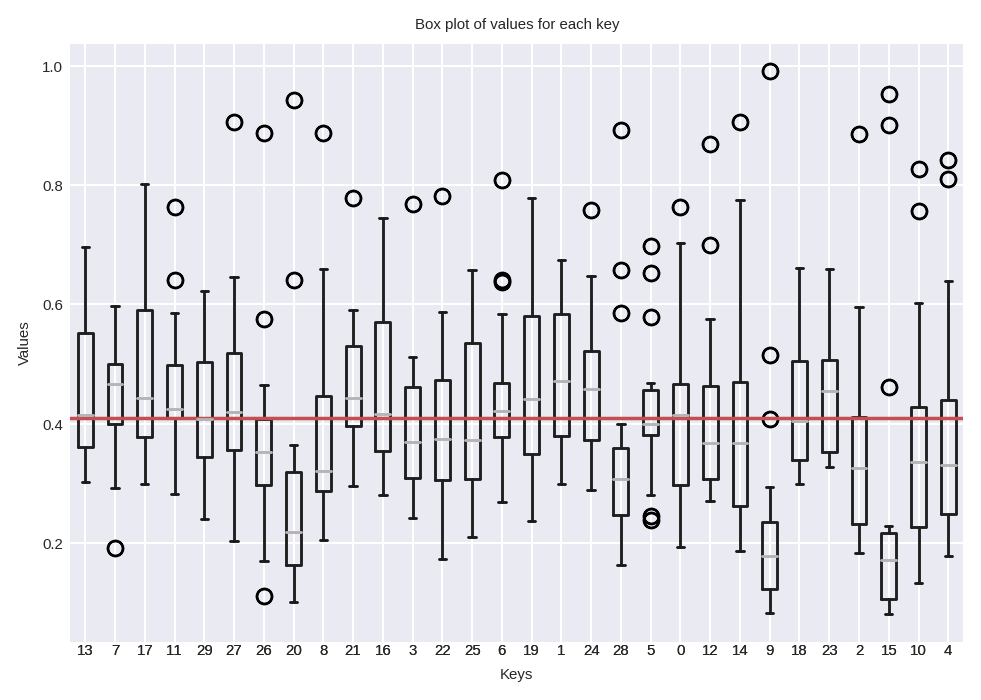

fma_winsize: 38
len(users_exp_df_dict): 30
0.40542345929431806


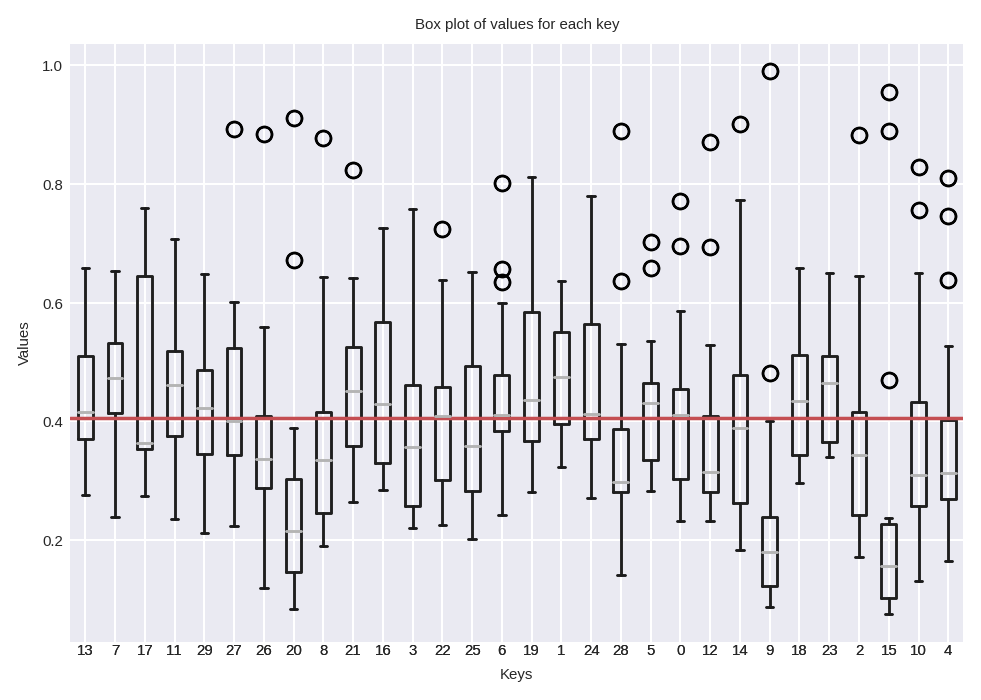

fma_winsize: 39
len(users_exp_df_dict): 30
0.40286114658720024


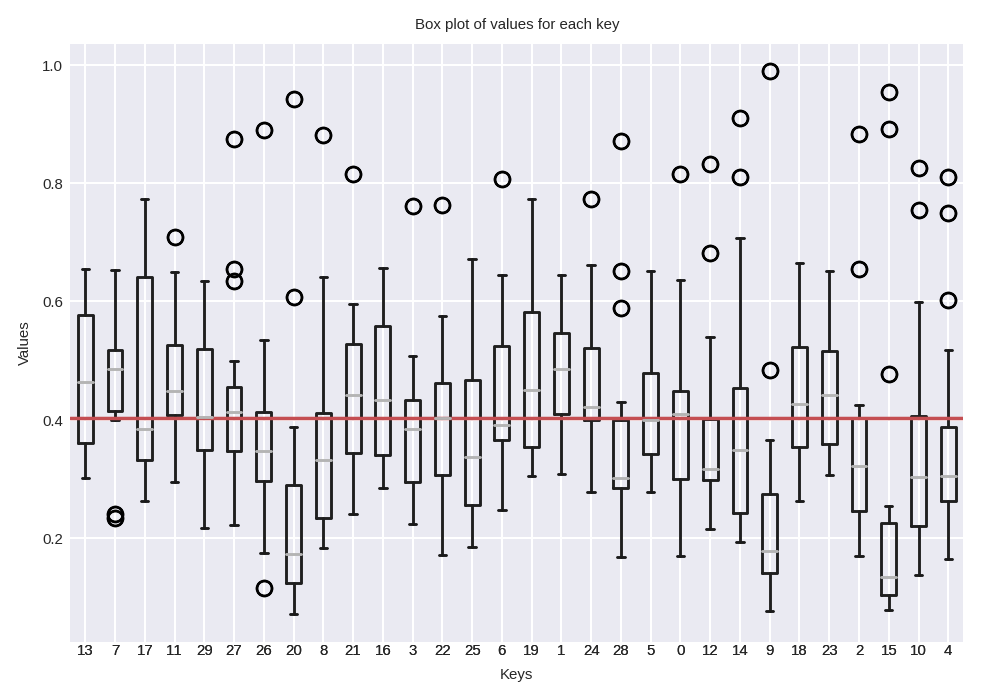

fma_winsize: 40
len(users_exp_df_dict): 30
0.40480669705089345


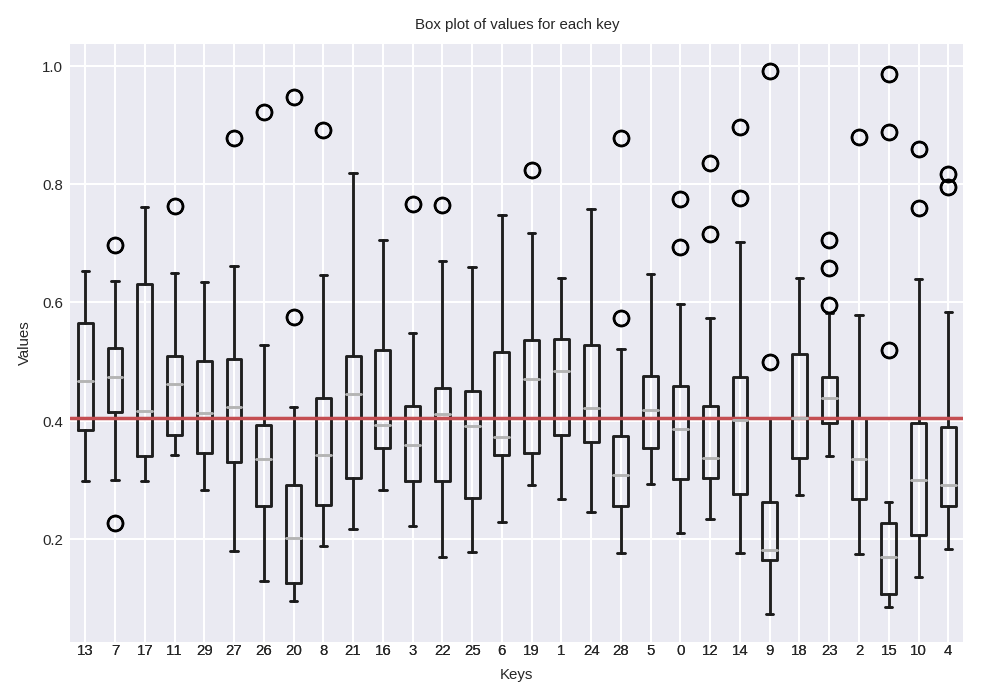

fma_winsize: 41
len(users_exp_df_dict): 30
0.40294180251921957


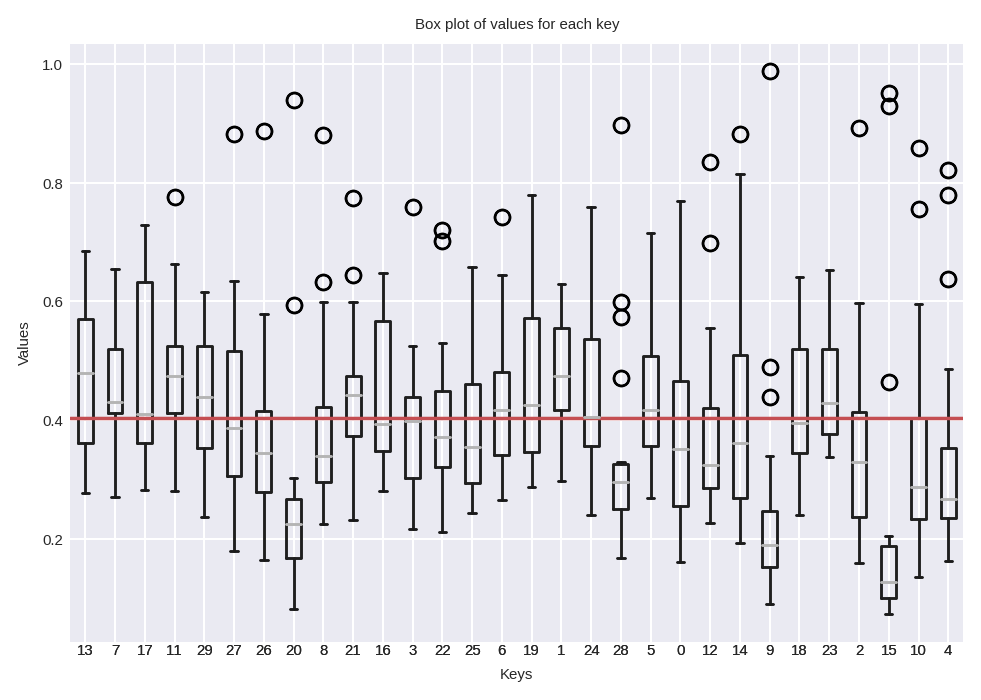

fma_winsize: 42
len(users_exp_df_dict): 30
0.40448678620021866


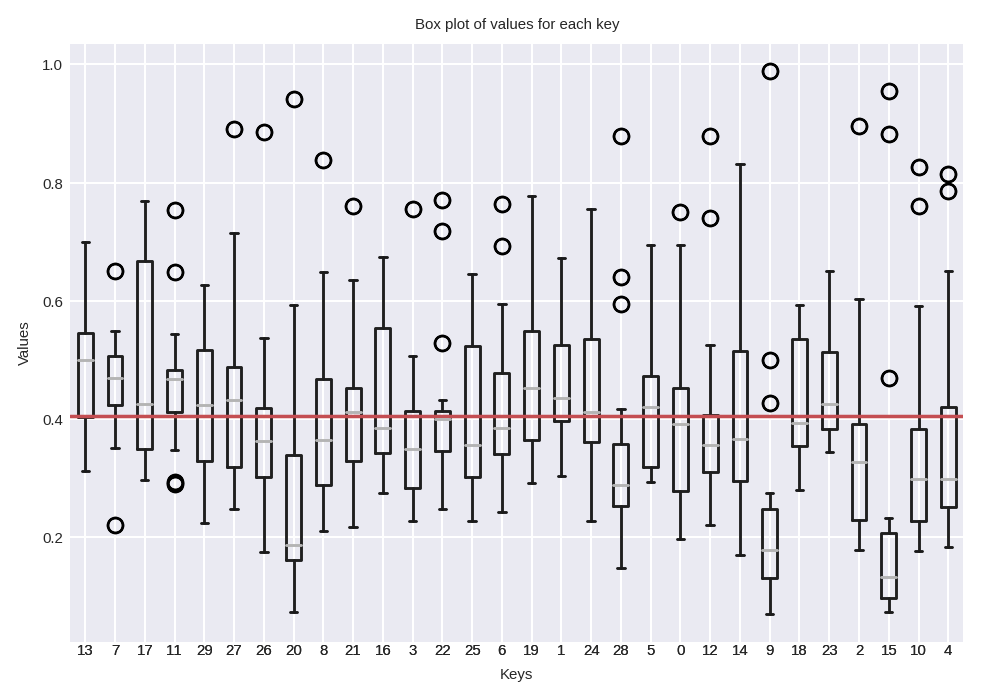

fma_winsize: 43
len(users_exp_df_dict): 30
0.40552070551507113


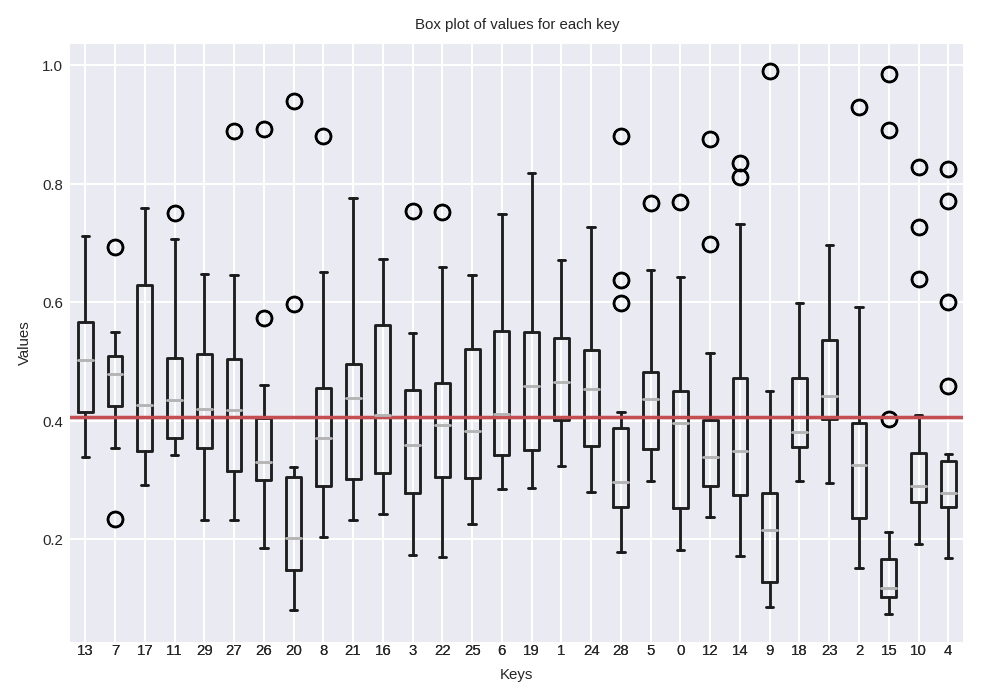

fma_winsize: 44
len(users_exp_df_dict): 30
0.40330741491999106


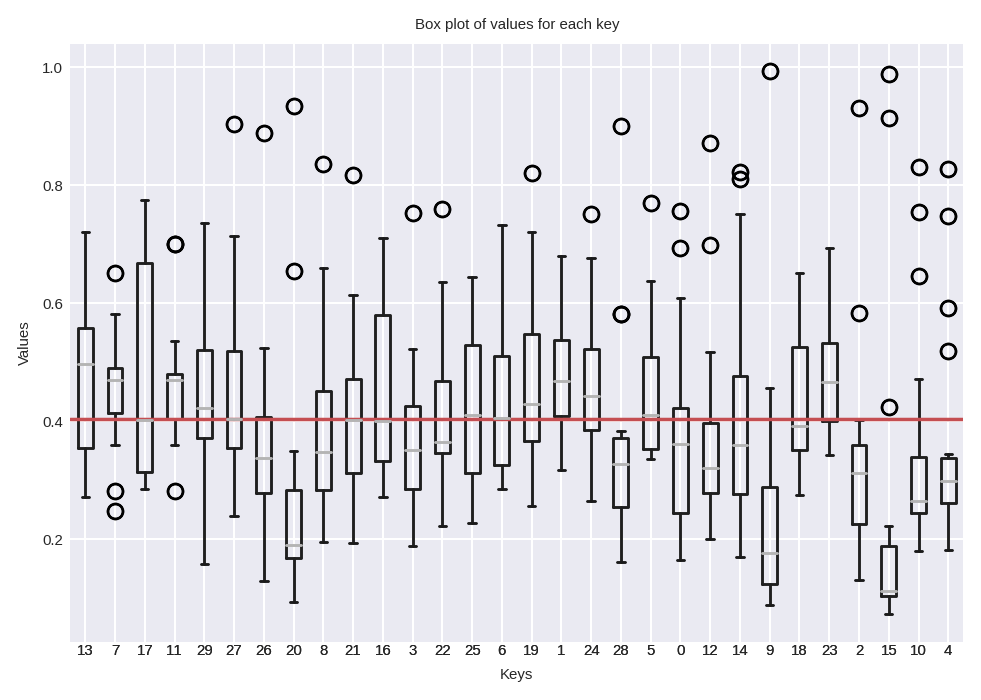

fma_winsize: 45
len(users_exp_df_dict): 30
0.4025419661265953


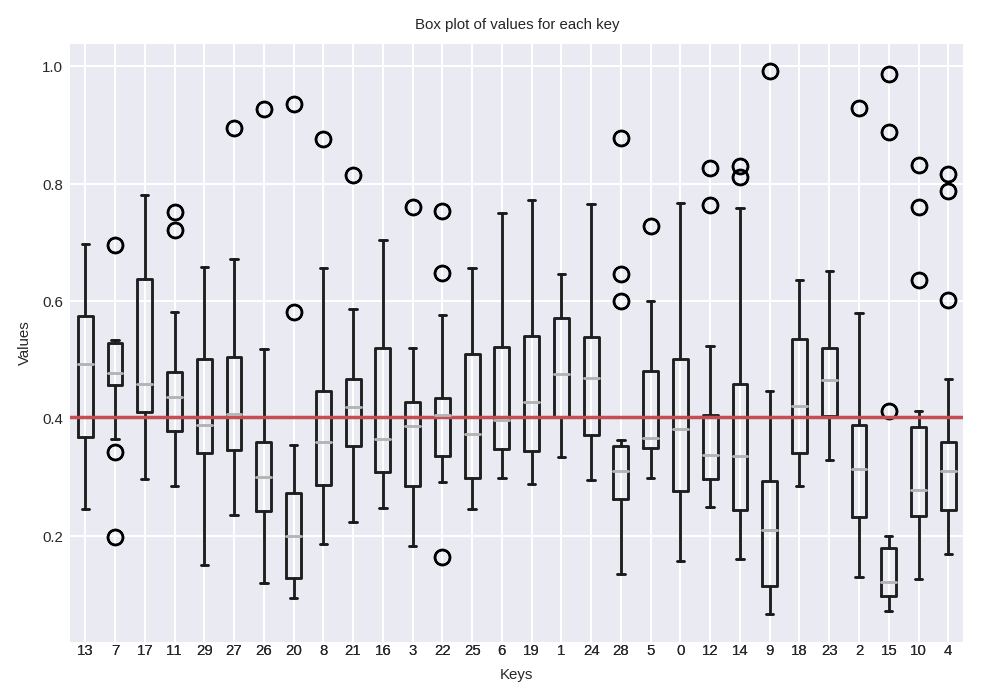

fma_winsize: 46
len(users_exp_df_dict): 30
0.39974352874397956


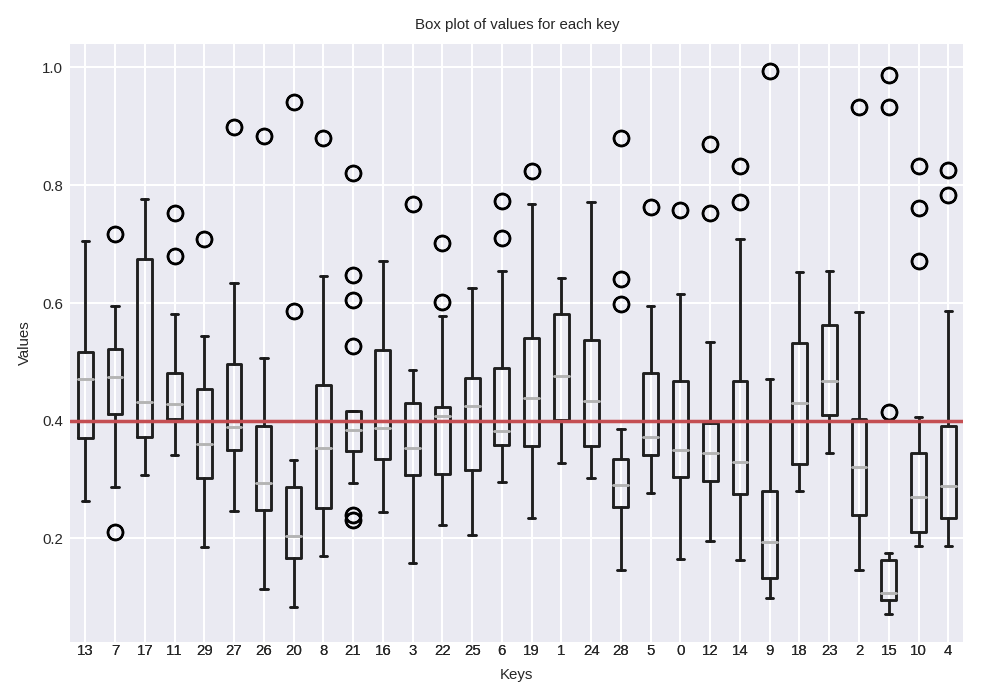

fma_winsize: 47
len(users_exp_df_dict): 30
0.3986863412883246


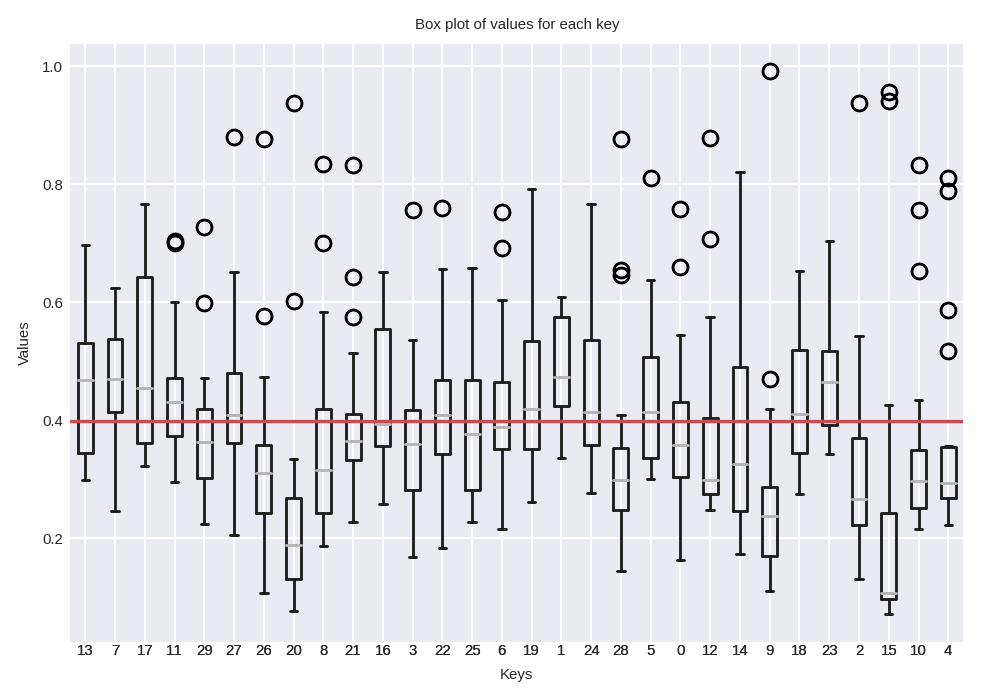

fma_winsize: 48
len(users_exp_df_dict): 30
0.3982111703770483


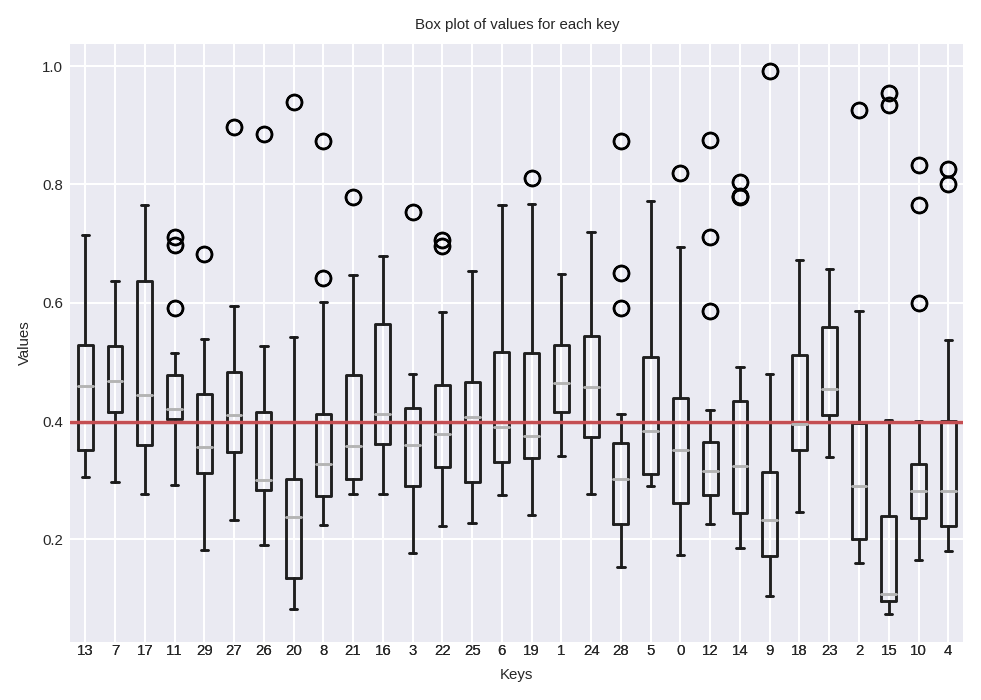

fma_winsize: 49
len(users_exp_df_dict): 30
0.39982178482291164


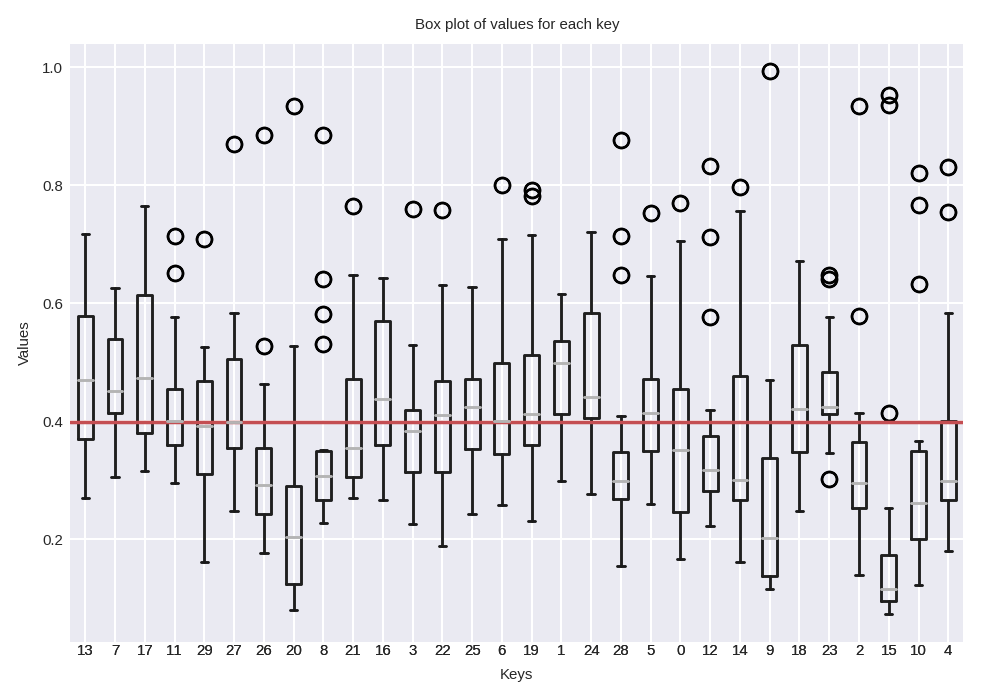

In [31]:
for fma_winsize in range(1, 50):
    print(f"fma_winsize: {fma_winsize}")
    result=make_dist_matrix_dict(raw_dfList_exp1, randomized_data_idx, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=fma_winsize)
    result=calculate_user_EER(result["owner_owner_dis_matrix_dict"], result["owner_adversary_dis_matrix_dict"], minkowski_p=2)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in result.items()]))

    # Create the box plot
    df.boxplot()


    # Calculate the average EER (assuming EER is in the data)
    average_eer = df.mean(axis=0).mean()

    print(average_eer)
    # Create the box plot
    df.boxplot()

    # Add a horizontal line for the average EER
    plt.axhline(y=average_eer, color='r', linestyle='-', label='Average EER')


    # Add labels and title
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.title("Box plot of values for each key")

    # Show the plot
    plt.show()